# Importation des libraries


In [1]:
import numpy as np
import pandas as pd
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
nltk.download('words')
nltk.download('punkt')
import json
import csv
import os
import random
import cv2
import seaborn as sns
import re
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import offsetbox
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet, words
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from yellowbrick.text import PosTagVisualizer
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.lda_model
english_words = set(words.words())
pyLDAvis.enable_notebook()

##

import os
import numpy as np
import cv2
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
#sauvegarde et chargement
from joblib import dump  
from joblib import load 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Les fonctions


### Téléchargement d'un échantillon de données d'avis et selection des avis négatifs


In [3]:
def load_and_preprocess_data(file_path, n_samples=5000):
    """
    Charge et pré-traite les données à partir d'un fichier JSON. La fonction lit le fichier,
    convertit les données en DataFrame, sélectionne les revues ayant un nombre d'étoiles
    inférieur ou égal à 2 et retourne un sous-ensemble aléatoire de ces revues.

    Args:
        file_path (str): Chemin d'accès au fichier JSON contenant les revues.
        n_samples (int, optional): Nombre de revues à sélectionner dans le sous-ensemble. Par défaut à 5000.

    Returns:
        pandas.DataFrame: Sous-ensemble de revues négatives sélectionnées aléatoirement.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        reviews = [json.loads(line) for line in f]
    reviews_df = pd.DataFrame(reviews)
    negative_reviews = reviews_df[reviews_df["stars"] <= 2] # selection des avis négatifs
    subset = negative_reviews.sample(n=n_samples, random_state=0)
    return subset

### fonctions pour la voir la structure des données sur les avis


In [4]:
def analyse_structure(df):
    """
    Analyse la structure d'un DataFrame pandas et affiche les informations pertinentes,
    telles que sa forme, le nombre de valeurs uniques dans chaque colonne, les types de données
    et les colonnes avec moins de 10 ou plus de 1000 valeurs uniques.

    Args:
        df (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche les informations directement.

    """
    print("Forme du Dataframe:", data.shape)
    print(data.info(), "\n")
    print(data.dtypes.value_counts(), "\n")
    print(data.nunique(), "\n")
    tmp = data.nunique()
    print(tmp[tmp < 10], "\n")
    print(tmp[tmp > 1000])

### Fonction pour le nétoyage des données


#### NaN et doublons


In [5]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print(data.duplicated().sum())
    print(data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

### Affichage des avis


In [6]:
def display_reviews(df, col):
    """
    Affiche la valeur de la colonne 'stars' et la valeur d'une autre colonne spécifiée pour un échantillon aléatoire
    d'une ligne du DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame contenant les revues.
        col (str): Nom de la colonne dont la valeur doit être affichée.

    Returns:
        None. Cette fonction affiche directement les informations.
    """
    rand_index = random.randint(0, df.shape[0])
    print(df.stars.iloc[rand_index])
    display(df[col].iloc[rand_index])

### visualisation des labels


In [7]:
def visualize_pos_tag(df):
    """
    Visualise les étiquettes de parties du discours (Part of Speech, POS) dans les commentaires (ou 'reviews')
    contenus dans le DataFrame fourni.

    Cette fonction utilise la bibliothèque nltk pour séparer les commentaires en phrases et en mots,
    et ensuite attribuer à chaque mot une étiquette de partie du discours. Elle utilise ensuite la classe
    PosTagVisualizer de la bibliothèque yellowbrick pour visualiser les résultats.

    Args:
        df (pandas.DataFrame): DataFrame contenant une colonne 'text' où chaque entrée est un commentaire à analyser.

    Returns:
        None. La fonction affiche un graphique horizontal montrant la fréquence de chaque étiquette POS.
    """
    list_reviews = [review for review in df.text.values]
    tagged_stanzas = []
    for paragraph in list_reviews:
        tagged_sentences = []
        sentences = nltk.sent_tokenize(paragraph)
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            tagged_words = nltk.pos_tag(words)
            tagged_sentences.append(tagged_words)
        tagged_stanzas.append(tagged_sentences)
    viz = PosTagVisualizer(orient="h")
    viz.fit(tagged_stanzas)
    viz.show()
    visualize_pos_tag(negative_reviews)

In [8]:
def visualize_pos_tag(df):
    """
    Visualise les étiquettes de parties du discours (Part of Speech, POS) dans les commentaires (ou 'reviews')
    contenus dans le DataFrame fourni.

    Cette fonction utilise la bibliothèque nltk pour séparer les commentaires en phrases et en mots,
    et ensuite attribuer à chaque mot une étiquette de partie du discours. Elle utilise ensuite la classe
    PosTagVisualizer de la bibliothèque yellowbrick pour visualiser les résultats.

    Args:
        df (pandas.DataFrame): DataFrame contenant une colonne 'text' où chaque entrée est un commentaire à analyser.

    Returns:
        None. La fonction affiche un graphique horizontal montrant la fréquence de chaque étiquette POS.
    """
    list_reviews = [review for review in df.text.values]
    tagged_stanzas = []
    for paragraph in list_reviews:
        tagged_sentences = []
        sentences = nltk.sent_tokenize(paragraph)
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            tagged_words = nltk.pos_tag(words)
            tagged_sentences.append(tagged_words)
        tagged_stanzas.append(tagged_sentences)
    viz = PosTagVisualizer(orient="h")
    viz.fit(tagged_stanzas)
    viz.show()

###


In [9]:
def get_wordnet_pos(treebank_tag):
    """
    Convertit les étiquettes de parties du discours (Part of Speech, POS) de Penn Treebank en format WordNet.

    Args:
        treebank_tag (str): Étiquette de partie du discours au format Penn Treebank.

    Returns:
        str: Étiquette de partie du discours au format WordNet.
    """
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # by default it is NOUN


def preprocess_text(text, english_words=english_words, min_len_word=3, rejoin=False):
    """
    Pré-traite un texte en réalisant plusieurs opérations : conversion en minuscules, suppression des caractères non
    alphabétiques, élimination des stop words, lemmatisation et filtration des mots courts.

    Args:
        text (str): Texte à pré-traiter.
        english_words (set): Ensemble des mots anglais à considérer.
        min_len_word (int): Longueur minimale des mots à conserver.
        rejoin (bool): Si True, renvoie le texte pré-traité sous forme d'une chaîne de caractères.

    Returns:
        list or str: Texte pré-traité sous forme d'une liste de mots ou d'une chaîne de caractères (si rejoin=True).
    """
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.split() if word not in stop_words]
    filtered_corpus = [word for word in words if word in english_words]

    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(filtered_corpus)
    words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words
    ]

    final_tokens = [w for w in words if len(w) >= min_len_word]

    if rejoin:
        return " ".join(final_tokens)

    return final_tokens

def clean_dataset(doc):
    """
    Nettoie un document en utilisant la fonction preprocess_text avec rejoin=True.

    Args:
        doc (str): Document à nettoyer.

    Returns:
        str: Document nettoyé.
    """
    new_doc = preprocess_text(doc, rejoin=True)
    return new_doc


### affichage des tokens


In [10]:
def display_tokens_info(tokens):
    """
    Affiche des informations sur une liste de tokens, notamment le nombre total de tokens,
    le nombre de tokens uniques et les 100 premiers tokens.

    Args:
        tokens (list of str): Liste de tokens.

    Returns:
        None. Cette fonction affiche directement les informations.
    """
    print(f"nombre tokens {len(tokens)}, nombres tokens uniques {len(set(tokens))}")
    print(tokens[:100])


# modelisation lda


In [11]:
def topic_modeling_lda(reviews, num_topics):
    """
    Vectorise (CountVectorizer) et crée le modèle LDA. Retourne modèle, vectorizer, vecteurs de sujet, matrice CountVectorizer.
    *** ATTENTION : LDA est généralement conçu pour fonctionner avec des comptes de mots (CountVectorizer).
    *** L'utilisation de CountVectorizer comme entrée pour LDA est moins courante et peut donner des résultats
    *** moins interprétables car le modèle probabiliste sous-jacent de LDA est basé sur des comptes.
    """
    print("--- Attention : Utilisation de CountVectorizer avec LDA ---")
    # --- Utilisation de CountVectorizer ---
    vectorizer = CountVectorizer(
        max_df=0.95, min_df=1, max_features=1000, stop_words="english"
        # Attention: stop_words='english' ici peut être redondant si preprocess_text les a déjà enlevés.
        # Si preprocess_text les enlève, mettez stop_words=None ici.
    )
    # --- La matrice résultante est une matrice CountVectorizer ---
    count_matrix = vectorizer.fit_transform(reviews)

    lda_model = LatentDirichletAllocation(
        n_components=num_topics, learning_method="online", random_state=0, max_iter=10 # max_iter peut nécessiter ajustement
    )

    # Gérer le cas où la matrice CountVectorizer est vide après vectorisation
    if count_matrix.shape[0] == 0 or count_matrix.shape[1] == 0:
         print("Attention : La matrice CountVectorizer est vide après vectorisation. LDA ne peut pas être entraîné.")
         # Retourner des valeurs par défaut ou lever une exception
         return None, vectorizer, np.array([]), count_matrix

    # --- Entraînement de LDA sur la matrice CountVectorizer (non standard) ---
    lda_model.fit(count_matrix)
    topic_vectors = lda_model.transform(count_matrix)

    # --- Retourne la matrice CountVectorizer au lieu de la matrice de comptage ---
    return lda_model, vectorizer, topic_vectors, count_matrix

# --- Définition des Classes Transformer pour le Pipeline ---


def display_topics(model, vectorizer, no_top_words=15):
    """
    Affiche les principaux mots pour chaque sujet généré par un modèle LDA.

    Args:
        model (LatentDirichletAllocation): Modèle LDA.
        vectorizer (CountVectorizer): Vectorizer utilisé pour transformer le corpus.
        no_top_words (int): Nombre de principaux mots à afficher pour chaque sujet.

    Returns:
        list of str: Liste de tous les mots uniques présents dans le corpus utilisés par le vectorizer.
    """
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]]
            )
        )
    return feature_names

In [12]:
dump(topic_modeling_lda, 'topic_modeling_lda.pkl')
dump(display_topics, 'display_topics.pkl')

['display_topics.pkl']

## Test de cohérence


In [13]:
def get_Cv(model, feature_names, df_column):
    """
    Calcule et renvoie le score de cohérence pour un modèle LDA, basé sur les 10 principaux mots de chaque sujet.
    Le score de cohérence mesure la qualité d'un modèle de sujet en examinant la cohérence des mots qui constituent chaque sujet.

    Args:
        model (LatentDirichletAllocation): Modèle LDA.
        feature_names (list of str): Liste des mots de fonctionnalité utilisés par le vectorizer.
        df_column (pandas.Series): Colonnes du DataFrame contenant les textes prétraités.

    Returns:
        float: Score de cohérence pour les 10 premiers mots de chaque sujet.
    """
    topics = model.components_
    n_top_words = 10
    texts = [[word for word in doc.split()] for doc in df_column]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
        )
    coherence_model = CoherenceModel(
        topics=top_words, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence = coherence_model.get_coherence()
    return coherence

In [14]:
dump(get_Cv, 'get_Cv.pkl')

['get_Cv.pkl']

## Visualisation du wordCloud


In [15]:
def plot_wordcloud(lda_model, lda_features_names, num_topics):
    """
    Affiche une visualisation de nuage de mots pour chaque sujet d'un modèle LDA.
    Chaque nuage de mots est basé sur les 10 mots les plus importants de chaque sujet.

    Args:
        lda_model (LatentDirichletAllocation): Modèle LDA.
        lda_features_names (list of str): Liste des mots de fonctionnalité utilisés par le vectorizer.
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.

    Returns:
        None. Cette fonction affiche directement les nuages de mots.
    """
    fig, axes = plt.subplots(int(num_topics / 2), 2, figsize=(10, 10))

    for i in range(num_topics):
        topic_words = lda_model.components_[i]
        top_word_indices = topic_words.argsort()[:-11:-1]
        wc_dict = {
            lda_features_names[index]: topic_words[index] for index in top_word_indices
        }
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(wc_dict)
        ax = axes[i // 2, i % 2]
        ax.set_title(f"Topic {i}")
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
    plt.tight_layout()
    plt.suptitle("Topics LDA", fontsize=16)
    plt.show()

In [16]:
dump(plot_wordcloud, 'plot_wordcloud.pkl')

['plot_wordcloud.pkl']

### Visiualisation des sujets


In [17]:
def plot_tsne(topic_vectors, num_topics=4):  
    """
    Affiche une visualisation t-SNE (t-Distributed Stochastic Neighbor Embedding) des sujets d'un modèle LDA.  
    Chaque point dans la visualisation représente un document, coloré en fonction de son sujet dominant.  

    Args:  
        topic_vectors (array-like): Vecteurs de sujet pour chaque document.  
                                    C'est la sortie de la méthode 'transform' d'un modèle LDA.  
        num_topics (int, optional): Nombre de sujets à visualiser. Par défaut à 4.  

    Returns:  
        numpy.ndarray: Tableau indiquant le sujet dominant pour chaque document.  
    """  
    # Identifier les sujets dominants pour chaque document  
    dominant_topics = np.argmax(topic_vectors, axis=1)  

    # Appliquer t-SNE  
    tsne_model = TSNE(n_components=2, random_state=0)  
    tsne_vectors = tsne_model.fit_transform(topic_vectors)  

    # Créer un DataFrame pour Plotly  
    df = pd.DataFrame(tsne_vectors, columns=['x', 'y'])  
    df['dominant_topic'] = dominant_topics.astype(str)  # Convertir les labels en string pour Plotly  

    # Définir une palette de couleurs pour les sujets  
    colors = px.colors.qualitative.Set1  # Utiliser une palette de couleurs qualitative  
    color_map = {str(i): colors[i] for i in range(num_topics)}  # Créer un dictionnaire de couleurs  

    # Créer la visualisation interactive avec Plotly  
    fig = px.scatter(df, x='x', y='y', color='dominant_topic',  
                     color_discrete_map=color_map,  
                     title='Visualisation t-SNE des sujets de modélisation LDA',  
                     labels={'dominant_topic': 'Sujet Dominant'},  
                     hover_name=df.index,  # Afficher l'index du document au survol pour plus d'informations  
                     template='plotly_white')  

    # Ajouter des options de mise en page  
    fig.update_traces(marker=dict(size=6, opacity=0.7), selector=dict(mode='markers'))  
    fig.update_layout(legend_title_text='Topics')  

    # Afficher la figure  
    fig.show()  

    return dominant_topics  

In [18]:
dump(plot_tsne, 'plot_tsne.pkl')

['plot_tsne.pkl']

In [19]:
def count_maj_topic(dominant_topics):
    """
    Compte le nombre de documents attribués à chaque sujet et imprime le sujet le plus courant.

    Args:
        dominant_topics (numpy.ndarray): Tableau indiquant le sujet dominant pour chaque document.

    Returns:
        None. Cette fonction imprime directement le sujet le plus courant et son nombre de documents.
    """
    topic_counts = Counter(dominant_topics)
    major_topic = topic_counts.most_common(1)[0]
    print(
        f"Le topic majoritaire est le sujet {major_topic[0]} avec {major_topic[1]} documents."
    )


In [20]:
dump(count_maj_topic, 'count_maj_topic.pkl')

['count_maj_topic.pkl']

###


In [21]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui effectue un prétraitement sur du texte,
    comme la mise en minuscule, le filtrage des stopwords, la lemmatisation, etc.
    """

    def __init__(self, english_words, min_len_word=3, rejoin=True):
        self.english_words = english_words
        self.min_len_word = min_len_word
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [
            preprocess_text(doc, self.english_words, self.min_len_word, self.rejoin)
            for doc in X
        ]


class TopicModeler(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui effectue une modélisation de sujet LDA sur du texte prétraité.
    """

    def __init__(self, num_topics=4):
        self.num_topics = num_topics

    def fit(self, X, y=None):
        (
            self.lda_model,
            self.count_vectorizer,
            self.topic_vectors,
            self.dtm,
        ) = topic_modeling_lda(X, self.num_topics)
        return self

    def transform(self, X):
        return self.lda_model.transform(self.count_vectorizer.transform(X))

In [22]:
dump(TextPreprocessor, 'TextPreprocessor.pkl')
dump(TopicModeler, 'TopicModeler.pkl')

['TopicModeler.pkl']

# Téléchargement des données sur les avis


In [ ]:
negative_reviews = load_and_preprocess_data("yelp_academic_dataset_review.json")

In [23]:
negative_reviews = pd.read_csv("negative_reviews5000.csv")

In [24]:
data = negative_reviews.copy()

### Structure du jeu de données


In [25]:
analyse_structure(data)

Forme du Dataframe: (5000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    5000 non-null   object 
 1   user_id      5000 non-null   object 
 2   business_id  5000 non-null   object 
 3   stars        5000 non-null   float64
 4   useful       5000 non-null   int64  
 5   funny        5000 non-null   int64  
 6   cool         5000 non-null   int64  
 7   text         5000 non-null   object 
 8   date         5000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 351.7+ KB
None 

object     5
int64      3
float64    1
Name: count, dtype: int64 

review_id      5000
user_id        4943
business_id    4609
stars             2
useful           31
funny            20
cool             15
text           5000
date           5000
dtype: int64 

stars    2
dtype: int64 

review_id      5000
user_id        4943
bus

### Nan et duplicated


review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64
0
0
col = review_id -> duplicated = 0
col = user_id -> duplicated = 57
col = business_id -> duplicated = 391
col = stars -> duplicated = 4998
col = useful -> duplicated = 4969
col = funny -> duplicated = 4980
col = cool -> duplicated = 4985
col = text -> duplicated = 0
col = date -> duplicated = 0


0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: text, Length: 5000, dtype: bool


stars       useful        funny         cool
count  5000.000000  5000.000000  5000.000000  5000.000000
mean      1.341600     1.499000     0.434000     0.187600
std       0.474294     2.776462     1.439326     0.846492
min       1.000000     0.000000     0.000000     0.000000
25%       1.000000     0.000000     0.000000     0.000000
50%       1.000000     1.000000     0.000000     0.000000
75%       2.000000     2.000000     0.000000     0.000000
max       2.000000    40.000000    51.000000    23.000000

review_id                 user_id  \
count                     5000                    5000   
unique                    5000                    4943   
top     Ssy6lXyaK4rEc90N8FCPmg  1p8Pu1pvAsuNtuZDtn2OkQ   
freq                         1                       3   

                   business_id  \
count                     5000   
unique                    4609   
top     IkY2ticzHEn4QFn8hQLSWg   
freq                         7   

                                                     text                 date  
count                                                5000                 5000  
unique                                               5000                 5000  
top     Terribly long wait times. Their A/C must be on...  2014-06-26 22:54:22  
freq                                                    1                    1

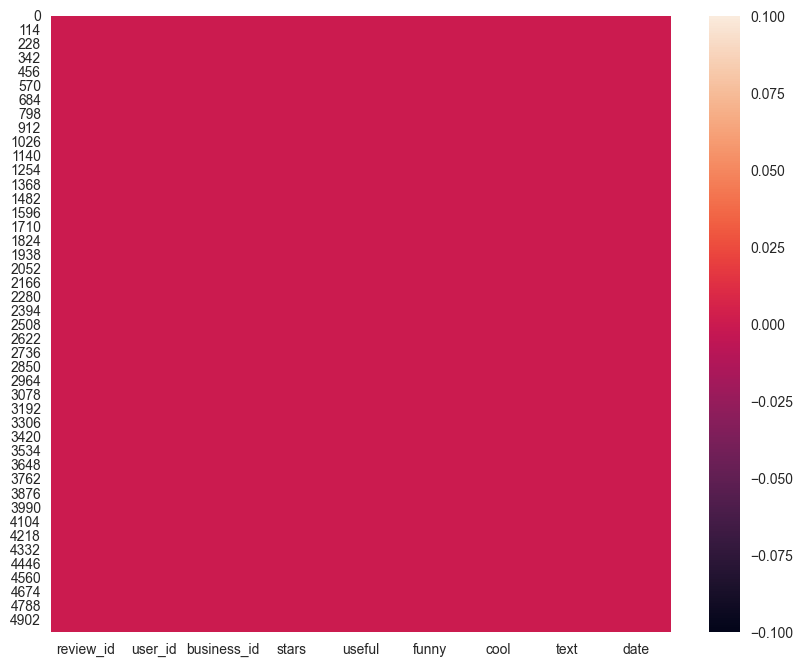

In [26]:
analyse_data(negative_reviews)

In [27]:
print(negative_reviews.text.apply(lambda x: len(x)))

0        405
1       1250
2       1721
3        204
4       1055
        ... 
4995     222
4996     259
4997    1092
4998     296
4999     719
Name: text, Length: 5000, dtype: int64


### Analyse des commentaires négatifs


Text(0.5, 1.0, 'Distribution du nombre de caractères des avis négatifs')

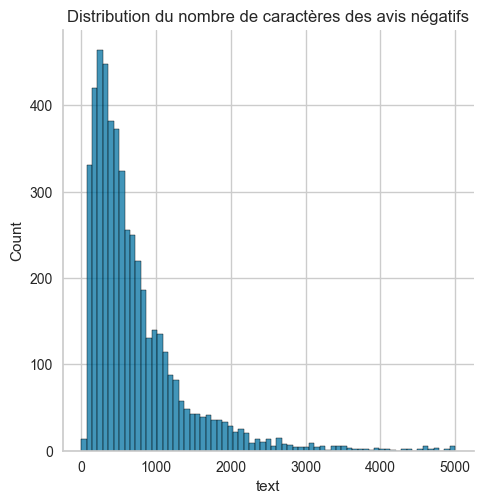

In [28]:
tmp = negative_reviews.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des avis négatifs")

In [29]:
negative_reviews.stars.value_counts()

stars
1.0    3292
2.0    1708
Name: count, dtype: int64

In [30]:
display_reviews(negative_reviews, "text")

1.0


"This was the worst meal I've ever had in my life. The eggs were hard, all the food was crusted over - and when I asked them to put out a few fresher items, they first said that they WERE fresh and then, when I pressed a little harder, they said they had no food except what was on the bar. The cook was wearing a Waffle House hat and spent his time sitting down and playing on his phone rather than cooking. Yikes!"

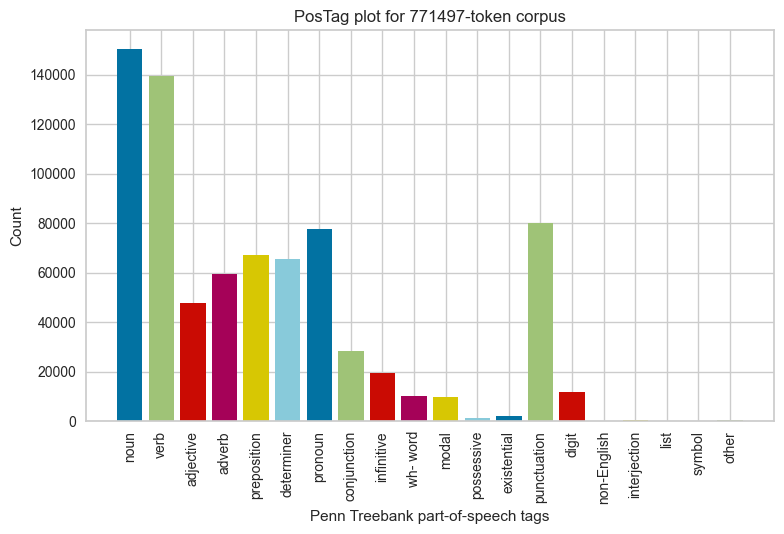

In [31]:
visualize_pos_tag(negative_reviews)

In [32]:
negative_reviews["cleaned_text"] = negative_reviews["text"].apply(clean_dataset)
negative_reviews.to_pickle("sample_text_data.pkl")

In [33]:
raw_corpus = " ".join(negative_reviews.text.values)
corpus = preprocess_text(raw_corpus)

In [34]:
display_reviews(negative_reviews, "cleaned_text")

2.0


'cover eight questionable big prob ugly bartender every time get beer look tip imagine ugly ass friend come people sit'

In [35]:
raw_corpus[:100]

'Terribly long wait times. Their A/C must be on the fritz, not only was the wait time close to 3 hour'

In [36]:
display_tokens_info(corpus)

nombre tokens 254886, nombres tokens uniques 9153
['terribly', 'long', 'wait', 'time', 'must', 'wait', 'time', 'close', 'temp', 'building', 'possibly', 'felt', 'like', 'sweat', 'shop', 'feel', 'people', 'work', 'even', 'good', 'disposition', 'time', 'get', 'help', 'hard', 'grouchy', 'next', 'time', 'pay', 'small', 'fee', 'road', 'express', 'get', 'soon', 'friend', 'get', 'sot', 'beef', 'lunch', 'soup', 'good', 'spicy', 'even', 'sure', 'felt', 'burn', 'admit', 'tend', 'eat', 'make', 'tear', 'bit', 'disappointed', 'unnamed', 'pile', 'stuff', 'good', 'tofu', 'come', 'whole', 'head', 'shell', 'even', 'sure', 'suppose', 'eat', 'soup', 'take', 'crack', 'open', 'feel', 'quite', 'primitive', 'process', 'friend', 'beautiful', 'flavor', 'however', 'bit', 'bland', 'something', 'bowl', 'hot', 'probably', 'also', 'due', 'user', 'error', 'certain', 'extent', 'rice', 'bottom', 'burn', 'together', 'bit', 'crispy', 'rice', 'pancake', 'good']


On observe dans les 30 premiers tokens, certains tokens intéressants dans le contexte de notre projet comme : disappointment, dirty, disgusting etc...


In [37]:
tmp = pd.Series(corpus).value_counts()
tmp.head(10)

get      3897
food     3029
time     2790
order    2520
would    2457
say      2375
one      2280
come     2253
place    2177
like     2158
Name: count, dtype: int64

## Traitement des mots rares


In [38]:
rare_words = tmp[tmp <= 5]
list_rare_words = rare_words.index.to_list()
tmp = pd.DataFrame({"words": rare_words})
tmp.to_csv("rare_words.csv", index=False)

In [39]:
print(
    "Nombres de mots dont la fréquence d'apparition est inférieure à 5:",
    len(list_rare_words),
)
print(rare_words.head(10))

Nombres de mots dont la fréquence d'apparition est inférieure à 5: 5822
palatable    5
bravo        5
parent       5
accent       5
reimburse    5
apt          5
stall        5
witch        5
floppy       5
tasted       5
Name: count, dtype: int64


perplexity pour optimiser le nombre de topic


### Bow : Bag of Words

- CountVectorizer: C'est l'implémentation la plus simple de BoW. Il convertit le texte en un vecteur sur la base du nombre d'occurrences de chaque mot dans le texte. Il compte simplement le nombre de fois qu'un mot apparaît dans le document.


### Modelisation de sujets : méthodes non supervisées

- LDA : LDA est une méthode probabiliste qui suppose que chaque document est une combinaison de sujets, et que chaque mot dans le document est attribué à l'un des sujets du document. LDA tente d'apprendre les distributions de sujets-mots et de documents-sujets qui ont probablement généré le corpus.


2025-04-28 18:49:47,906 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-28 18:49:48,653 : INFO : built Dictionary<46322 unique tokens: ['...next', '3', '80', 'A/C', 'AZ']...> from 5000 documents (total 677854 corpus positions)
2025-04-28 18:49:48,654 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<46322 unique tokens: ['...next', '3', '80', 'A/C', 'AZ']...> from 5000 documents (total 677854 corpus positions)", 'datetime': '2025-04-28T18:49:48.654931', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2025-04-28 18:49:49,155 : INFO : Début du calcul de cohérence (via get_Cv_gensim) pour 4 modèles (topics de 2 à 5 par pas de 1)...
2025-04-28 18:49:49,158 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2025-04-28 18:49:49,173 : INFO : using serial LDA version on this node
2025-04-28 18:49:49,188 : INFO : running online (m


Le nombre optimal de topics (basé sur get_Cv_gensim) est : 4
Scores de cohérence (get_Cv_gensim) par nombre de topics :
  2 topics : 0.2691
  3 topics : 0.3625
  4 topics : 0.3780
  5 topics : 0.3623


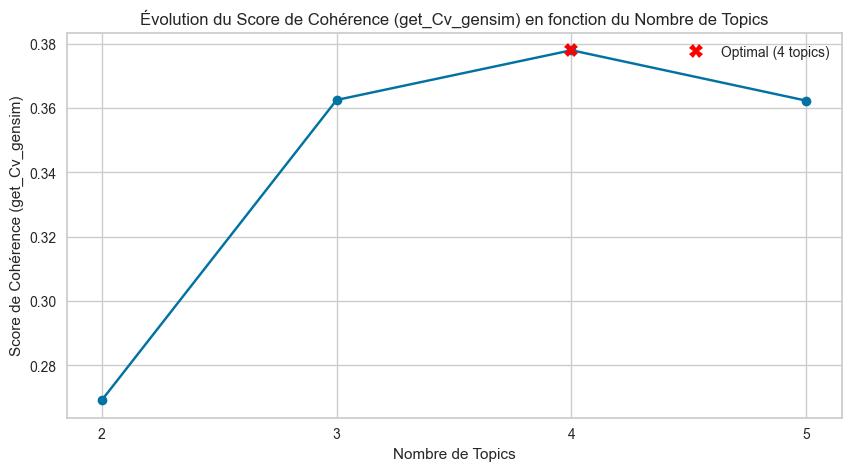

In [40]:
import gensim
# from gensim.models import CoherenceModel # Plus nécessaire ici directement
import matplotlib.pyplot as plt
import logging
# Assurez-vous que corpora est importé si vous utilisez l'ancienne get_Cv ailleurs
# import gensim.corpora as corpora

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# ==============================================================================
# DÉFINITION DE LA FONCTION DE COHÉRENCE (Version adaptée pour Gensim)
# ==============================================================================
from gensim.models import CoherenceModel # Nécessaire pour get_Cv_gensim

def get_Cv_gensim(model, texts, dictionary, coherence_type='c_v'):
    """
    Calcule et renvoie le score de cohérence pour un modèle LDA Gensim.
    (Définition complète comme ci-dessus)
    """
    if not texts or not dictionary or not model:
        logging.error("Modèle, Textes ou Dictionnaire manquant pour le calcul de cohérence.")
        return None
    try:
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence=coherence_type
        )
        coherence = coherence_model.get_coherence()
        return coherence
    except Exception as e:
        logging.error(f"Erreur lors du calcul de la cohérence ({coherence_type}) dans get_Cv_gensim: {e}")
        return None
# ==============================================================================


def find_optimal_number_of_topics(dictionary, corpus, texts, limit, start=2, step=3, random_state=100, passes=10, iterations=50, chunksize=100):
    """
    Calcule les scores de cohérence en utilisant get_Cv_gensim pour différents nombres de topics
    et retourne le nombre de topics optimal.

    Args:
        dictionary (gensim.corpora.Dictionary): Le dictionnaire Gensim.
        corpus (list): Le corpus au format BoW Gensim.
        texts (list of list of str): La liste des textes prétraités (liste de listes de tokens),
                                     utilisée par get_Cv_gensim.
        limit (int): Le nombre maximum de topics à tester (exclusif).
        start (int, optional): Le nombre minimum de topics à tester. Défaut à 2.
        step (int, optional): L'incrément entre les nombres de topics testés. Défaut à 3.
        random_state (int, optional): Graine pour la reproductibilité. Défaut à 100.
        passes (int, optional): Nombre de passes LDA. Défaut à 10.
        iterations (int, optional): Nombre d'itérations LDA. Défaut à 50.
        chunksize (int, optional): Taille des chunks LDA. Défaut à 100.

    Returns:
        tuple: (optimal_num_topics, coherence_scores)
    """
    coherence_values = []
    model_list = []
    topic_numbers = list(range(start, limit, step))

    if not topic_numbers:
        logging.warning(f"La plage de topics spécifiée (start={start}, limit={limit}, step={step}) est vide.")
        return None, {}

    logging.info(f"Début du calcul de cohérence (via get_Cv_gensim) pour {len(topic_numbers)} modèles (topics de {start} à {limit-1} par pas de {step})...")

    for num_topics in topic_numbers:
        try:
            # Entraînement du modèle LDA Gensim
            model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=dictionary, # Utilise le dictionnaire Gensim
                num_topics=num_topics,
                random_state=random_state,
                update_every=1,
                chunksize=chunksize,
                passes=passes,
                iterations=iterations,
                alpha='auto',
                eta='auto',
                per_word_topics=True
            )
            model_list.append(model)

            # --- MODIFICATION ICI ---
            # Calcul du score de cohérence en utilisant notre fonction adaptée get_Cv_gensim
            logging.debug(f"Appel de get_Cv_gensim pour {num_topics} topics...")
            coherence = get_Cv_gensim(model=model, texts=texts, dictionary=dictionary) # Appel de la fonction adaptée
            # --- FIN DE LA MODIFICATION ---

            if coherence is not None:
                coherence_values.append(coherence)
                logging.info(f"Nombre de Topics = {num_topics} -> Score de Cohérence (get_Cv_gensim) = {coherence:.4f}")
            else:
                logging.warning(f"get_Cv_gensim a retourné None pour {num_topics} topics. Ce point sera ignoré.")
                coherence_values.append(None)

        except Exception as e:
            # Capture d'autres erreurs potentielles (entraînement LDA, etc.)
            logging.error(f"Erreur lors de l'entraînement ou du calcul de cohérence pour {num_topics} topics: {e}")
            coherence_values.append(None)

    # Filtrer les éventuels échecs (None) avant de chercher le max
    valid_scores = [(topic_numbers[i], score) for i, score in enumerate(coherence_values) if score is not None]

    if not valid_scores:
        logging.warning("Aucun score de cohérence n'a pu être calculé avec succès via get_Cv_gensim.")
        return None, {}

    # Trouver le nombre de topics avec le score maximal
    optimal_num_topics, max_coherence = max(valid_scores, key=lambda item: item[1])
    coherence_scores_dict = dict(valid_scores)

    logging.info(f"Calcul terminé. Nombre optimal de topics trouvé : {optimal_num_topics} (Score get_Cv_gensim = {max_coherence:.4f})")

    return optimal_num_topics, coherence_scores_dict


tokenized_texts = [text.split() for text in negative_reviews["text"]]
#    If negative_reviews["text"] is already a list of strings:
#    tokenized_texts = [text.split() for text in lemmatized_texts] # Use this if lemmatized_texts was already a list

# --- ÉTAPES PRÉALABLES (Exemple) ---
# (Assurez-vous que lemmatized_texts, dictionary, corpus sont définis comme avant)

# NOW use the tokenized list:
dictionary = gensim.corpora.Dictionary(tokenized_texts) # Use tokenized_texts here
corpus = [dictionary.doc2bow(text) for text in tokenized_texts] # And here
# --- FIN DES ÉTAPES PRÉALABLES ---


# --- Utilisation de la fonction ---
start_topics = 2
limit_topics = 6
step_topics = 1

# Appeler la fonction (qui utilise maintenant get_Cv_gensim en interne)
optimal_topics, coherence_scores = find_optimal_number_of_topics(
    dictionary=dictionary,
    corpus=corpus,
    texts=tokenized_texts, # <-- CORRECTED: Use the tokenized list
    limit=limit_topics,
    start=start_topics,
    step=step_topics,
    passes=5,        # Example parameters, adjust as needed
    iterations=30    # Example parameters, adjust as needed
)

# ... (rest of your plotting and printing code remains the same) ...

# Afficher les résultats
if optimal_topics is not None:
    print(f"\nLe nombre optimal de topics (basé sur get_Cv_gensim) est : {optimal_topics}")
    print("Scores de cohérence (get_Cv_gensim) par nombre de topics :")
    for topics, score in coherence_scores.items():
        print(f"  {topics} topics : {score:.4f}")

    # Optionnel : Visualiser les scores de cohérence
    try:
        import matplotlib.pyplot as plt # Ensure matplotlib is imported if not done globally
        x = list(coherence_scores.keys())
        y = list(coherence_scores.values())
        plt.figure(figsize=(10, 5))
        plt.plot(x, y, marker='o')
        plt.xlabel("Nombre de Topics")
        plt.ylabel("Score de Cohérence (get_Cv_gensim)")
        plt.title("Évolution du Score de Cohérence (get_Cv_gensim) en fonction du Nombre de Topics")
        plt.xticks(x) # Ensure ticks match the actual topic numbers tested
        plt.grid(True)
        # Highlight the optimal point
        if optimal_topics in coherence_scores: # Check if optimal_topics key exists
             plt.plot(optimal_topics, coherence_scores[optimal_topics], marker='X', color='red', markersize=10, linestyle='None', label=f'Optimal ({optimal_topics} topics)')
        plt.legend()
        plt.show()
    except ImportError:
        print("\nMatplotlib non trouvé. Installez-le (`pip install matplotlib`) pour visualiser les scores.")
    except Exception as e:
        print(f"\nErreur lors de la création du graphique : {e}")
else:
    print("\nImpossible de déterminer le nombre optimal de topics avec les paramètres fournis (en utilisant get_Cv_gensim).")

In [41]:
optimal_topics

4

In [42]:
num_topics = optimal_topics

In [43]:
preprocessed_reviews = [review for review in negative_reviews.cleaned_text.values]
lda_model, count_vectorizer, topic_vectors, dtm = topic_modeling_lda(
    preprocessed_reviews, num_topics=optimal_topics

)
print("LDA Topics:")
lda_features_names = display_topics(lda_model, count_vectorizer)

--- Attention : Utilisation de CountVectorizer avec LDA ---
LDA Topics:
Topic 0:
say tell service customer time make day store business phone manager try come know company
Topic 1:
food good order like place chicken taste pizza really eat cheese bad time try sauce
Topic 2:
car like time place room look tell say work come day stay bad leave hotel
Topic 3:
food order come time wait service table say place restaurant bar sit good people make


In [44]:
count_vectorizer

CountVectorizer(max_df=0.95, max_features=1000, stop_words='english')

In [45]:
topic_vectors

array([[0.17801866, 0.01045712, 0.60729995, 0.20422427],
       [0.05596016, 0.93497344, 0.0045563 , 0.0045101 ],
       [0.66944351, 0.00331529, 0.32386108, 0.00338013],
       ...,
       [0.0062486 , 0.0060684 , 0.98153759, 0.00614542],
       [0.01751958, 0.01736218, 0.94777839, 0.01733984],
       [0.00885131, 0.009002  , 0.00897076, 0.97317593]])

#### Mesures de cohérence

Examinons rapidement les différentes mesures de cohérence et leur mode de calcul :

1. la mesure C_v est basée sur une fenêtre coulissante, une segmentation en un seul ensemble des mots les plus importants et une mesure de confirmation indirecte qui utilise l'information mutuelle ponctuelle normalisée (NPMI) et la similarité cosinus.

2. la mesure C_uci est basée sur une fenêtre coulissante et l'information mutuelle ponctuelle (PMI) de toutes les paires de mots des mots principaux donnés

3. la mesure C_umass est basée sur le nombre de cooccurrences dans les documents, une segmentation à un précédant et une probabilité conditionnelle logarithmique comme mesure de confirmation

4. C_npmi est une version améliorée de la cohérence C_uci utilisant l'information mutuelle ponctuelle normalisée (NPMI).


In [46]:
coherence = get_Cv(lda_model, lda_features_names, negative_reviews.cleaned_text)
print("Score de cohérence pour les 10 premiers mots de chaques topics:", coherence)

2025-04-28 18:54:36,973 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-28 18:54:37,196 : INFO : built Dictionary<9161 unique tokens: ['building', 'close', 'disposition', 'even', 'express']...> from 5000 documents (total 254885 corpus positions)
2025-04-28 18:54:37,197 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<9161 unique tokens: ['building', 'close', 'disposition', 'even', 'express']...> from 5000 documents (total 254885 corpus positions)", 'datetime': '2025-04-28T18:54:37.197569', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2025-04-28 18:54:37,349 : INFO : using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
2025-04-28 18:54:51,257 : INFO : 11 accumulators retrieved from output queue
2025-04-28 18:54:51,269 : INFO : accumulated word occurrence stats fo

Score de cohérence pour les 10 premiers mots de chaques topics: 0.47226127747995506


In [47]:
dump(lda_model, 'lda_model.pkl')
dump(lda_features_names, 'lda_features_names.pkl')

['lda_features_names.pkl']

In [48]:
lda_model

LatentDirichletAllocation(learning_method='online', n_components=4,
                          random_state=0)

#### Visualisation


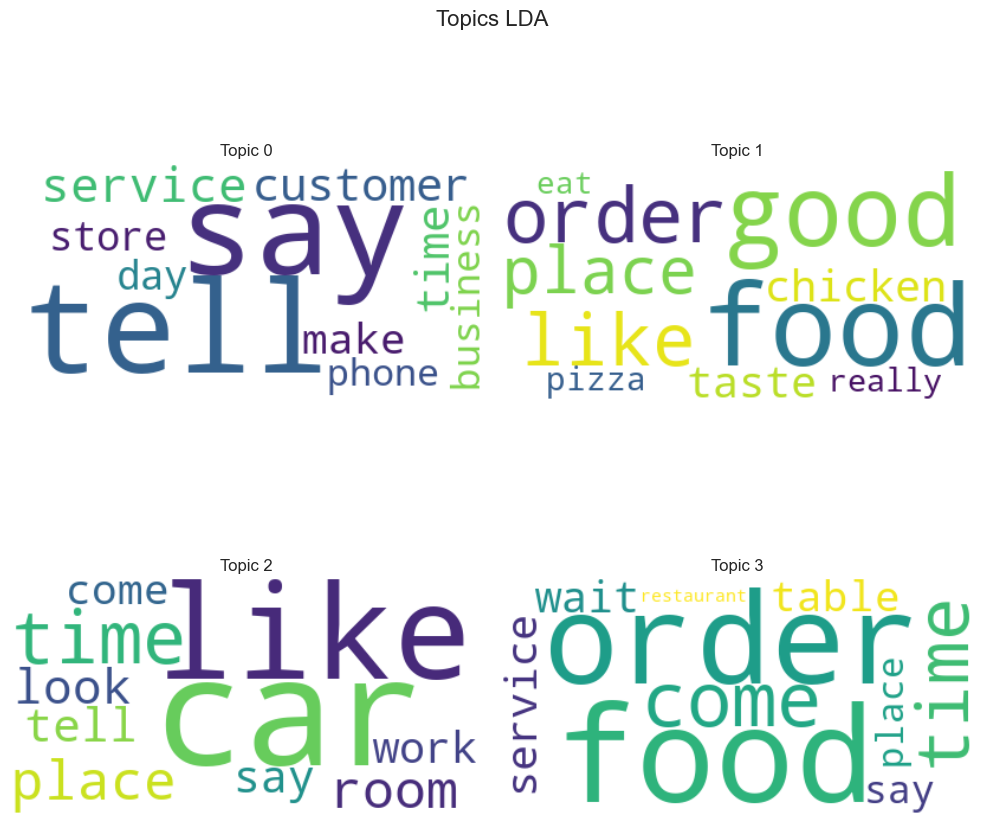

In [49]:
plot_wordcloud(lda_model, lda_features_names,num_topics)

Ces résultats montrent les sujets principaux trouvés par l'analyse LDA. Chaque sujet est représenté par un ensemble de mots qui ont la plus grande probabilité d'apparaître dans ce sujet.
Comme cité précèdemment, LDA semble en mesure de parcourir les thèmes généraux qui sont présents dans les documents, ces thèmes balayent :

- des problèmes liés au service à la clientèle, et plus précisément à la gestion des commandes.
- des sujets concernant la qualité de la nourriture et le service dans les restaurants.
- des sujets concernant des services automobiles, et plus précisement les temps de livraison.
- des sujets qui se concentre sur les hôtels, abordant des thèmes tels que la propreté des chambres, le personnel et les services offerts


In [50]:
pyLDAvis.lda_model.prepare(lda_model, dtm, count_vectorizer, mds="mmds")

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.099366 -0.061401       1        1  27.656397
1     -0.130763  0.173298       2        1  25.771674
0      0.105160 -0.176337       3        1  24.739153
2      0.124969  0.064440       4        1  21.832776, topic_info=        Term         Freq        Total Category  logprob  loglift
354     food  3004.000000  3004.000000  Default  30.0000  30.0000
130      car   674.000000   674.000000  Default  29.0000  29.0000
875    table   880.000000   880.000000  Default  28.0000  28.0000
605    order  2501.000000  2501.000000  Default  27.0000  27.0000
153  chicken   686.000000   686.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
627   people   233.900886  1003.092144   Topic4  -5.0452   0.0658
703   really   230.604174  1049.320704   Topic4  -5.0594   0.0066
584    night   198.047272   540.181587   Topic4  -5.2116   0.5184
387     good   242.765957  1948.598110   Topic4  -5.0080  -0.5610
624      pay   199.452585   636.429326   Topic4  -5.2046   0.3615

[303 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5         3  0.992961      account
6         1  0.985414  acknowledge
13        3  0.981967      address
21        1  0.052139          air
21        3  0.010428          air
...     ...       ...          ...
977       2  0.044510         wine
983       1  0.205527         work
983       2  0.011837         work
983       3  0.380924         work
983       4  0.402445         work

[500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

### Réduction de dimensionnalité


Les vecteurs de sujets, qui sont les sorties du modèle LDA, représentent la répartition des sujets pour chaque commentaire. Ils capturent l'information de haut niveau sur les "sujets" ou les thèmes principaux présents dans chaque commentaire. L'application de t-SNE sur ces vecteurs donnera une visualisation en 2D où chaque point représente un commentaire et les commentaires similaires en termes de sujets seront regroupés ensemble.


In [53]:
dominant_topics = plot_tsne(topic_vectors)

In [54]:
count_maj_topic(dominant_topics) 

Le topic majoritaire est le sujet 1 avec 1557 documents.


#### Enchaînement des étapes de nettoyage et de création de variables


In [55]:
text_pipeline = Pipeline(
    [
        (
            "preprocessing",
            TextPreprocessor(english_words=english_words, min_len_word=3, rejoin=True),
        ),
        ("topic_modeling", TopicModeler(num_topics=4))
    ]
)

In [56]:
dump(text_pipeline, 'text_pipeline.joblib')

['text_pipeline.joblib']

In [57]:
transformed_data = text_pipeline.fit_transform(negative_reviews["text"])

--- Attention : Utilisation de CountVectorizer avec LDA ---


In [58]:
dump(transformed_data, 'transformed_data.joblib')

['transformed_data.joblib']

In [59]:
print(transformed_data)
print(transformed_data.shape)

[[0.17801866 0.01045712 0.60729995 0.20422427]
 [0.05596016 0.93497344 0.0045563  0.0045101 ]
 [0.66944351 0.00331529 0.32386108 0.00338013]
 ...
 [0.0062486  0.0060684  0.98153759 0.00614542]
 [0.01751958 0.01736218 0.94777839 0.01733984]
 [0.00885131 0.009002   0.00897076 0.97317593]]
(5000, 4)


transformed_data correspond bien aux vecteurs de sujets renvoyé par LDA.


In [60]:
topic_vectors

array([[0.17801866, 0.01045712, 0.60729995, 0.20422427],
       [0.05596016, 0.93497344, 0.0045563 , 0.0045101 ],
       [0.66944351, 0.00331529, 0.32386108, 0.00338013],
       ...,
       [0.0062486 , 0.0060684 , 0.98153759, 0.00614542],
       [0.01751958, 0.01736218, 0.94777839, 0.01733984],
       [0.00885131, 0.009002  , 0.00897076, 0.97317593]])

### Prédiction de topic d'un commentaire

In [61]:
def topic_predict(texte_unique_raw):

    # Préparer le document unique (review0)
    # Assurons-nous que review0 est bien une structure itérable comme une liste ou une Series
    # Utiliser le pipeline entraîné pour prédire le topic d'un nouveau texte
    review0_iterable = [texte_unique_raw] # Doit être un itérable (liste ou Series)

    print(f"\nPrédiction du topic pour le texte : '{texte_unique_raw}'")

    try:
        # Obtenir la distribution de probabilité des topics pour le texte unique
        topic_distribution = text_pipeline.transform(review0_iterable)

        # Trouver le numéro du topic le plus probable (index du max)
        numero_topic_predit = np.argmax(topic_distribution, axis=1)[0]

        print(f"Distribution de probabilité : {topic_distribution[0]}")
        print(f"Le numéro du topic prédit (0 à {num_topics-1}) est : {numero_topic_predit}")

        # Optionnel : Afficher les mots clés pour interpréter les topics (si l'entraînement a réussi)
        if hasattr(text_pipeline.named_steps['topic_modeling'], 'lda_model') and \
        text_pipeline.named_steps['topic_modeling'].lda_model is not None:
            print("\n--- Mots clés par topic (appris lors du fit) ---")
            vectorizer = text_pipeline.named_steps['topic_modeling'].count_vectorizer
            lda_model = text_pipeline.named_steps['topic_modeling'].lda_model
            feature_names = vectorizer.get_feature_names_out()
            n_top_words = 7
            for topic_idx, topic_loadings in enumerate(lda_model.components_):
                top_words_indices = topic_loadings.argsort()[:-n_top_words - 1:-1]
                top_words = [feature_names[i] for i in top_words_indices]
                print(f"Topic {topic_idx}: {', '.join(top_words)}")
        else:
            print("\nImpossible d'afficher les mots clés (modèle non entraîné correctement).")

    except Exception as e:
        print(f"Erreur pendant la transformation/prédiction : {e}")

In [62]:
dump(transformed_data, 'transformed_data.joblib')

['transformed_data.joblib']

In [63]:
topic_predict(str(negative_reviews["text"][0]))


Prédiction du topic pour le texte : 'Terribly long wait times. Their A/C must be on the fritz, not only was the wait time close to 3 hours, with the temp in the building possibly over 80 degrees it felt like a sweat shop. I feel for the people working, under those conditions even if you have a good disposition, by the time you get help it's hard to not be grouchy. 

...next time I'm paying a small fee to go down the road to AZ MV Express.'
Distribution de probabilité : [0.17801866 0.01045712 0.60729995 0.20422427]
Le numéro du topic prédit (0 à 3) est : 2

--- Mots clés par topic (appris lors du fit) ---
Topic 0: say, tell, service, customer, time, make, day
Topic 1: food, good, order, like, place, chicken, taste
Topic 2: car, like, time, place, room, look, tell
Topic 3: food, order, come, time, wait, service, table


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning:

This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.



In [ ]:
print(Arrêt)

## Analyse des images


In [ ]:
def load_image_data(file_path, n_samples=None):
    """
    Charge les données d'image depuis un fichier JSON et renvoie un DataFrame pandas.
    Si n_samples est spécifié, un sous-ensemble aléatoire des données est renvoyé.

    Args:
        file_path (str): Chemin vers le fichier de données à lire.
        n_samples (int, optional): Nombre d'échantillons à sélectionner aléatoirement. Si None, toutes les données sont utilisées.

    Returns:
        pandas.DataFrame: DataFrame contenant les données d'image.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        images = [json.loads(line) for line in f]
    df_images = pd.DataFrame(images)

    if n_samples:
        df_images = df_images.sample(n=n_samples)
    return df_images

In [ ]:
df_images = load_image_data("data/photos.json")

In [ ]:
def analyse_image(df):
    """
    Analyse un DataFrame contenant des données d'image. Affiche les cinq premières lignes,
    la forme du DataFrame, le nombre de doublons basé sur 'photo_id', les valeurs manquantes,
    le nombre de valeurs uniques par colonne et la distribution des valeurs de la colonne 'label'.

    Args:
        df (pandas.DataFrame): DataFrame contenant les données d'image à analyser.

    Returns:
        None. Les résultats sont affichés directement.
    """
    display(df.head())
    print(df.shape, "\n")
    print("Nombres de duplicatas :", df.photo_id.duplicated().sum(), "\n")
    df.drop_duplicates(subset="photo_id", inplace=True)
    print(df.isna().mean(), "\n")
    print("Nombre de données uniques: \n", df.nunique(), "\n")
    print(df.label.value_counts())

In [ ]:
analyse_image(df_images)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

(200100, 4) 

Nombres de duplicatas : 2 

photo_id       0.0
business_id    0.0
caption        0.0
label          0.0
dtype: float64 

Nombre de données uniques: 
 photo_id       200098
business_id     36680
caption         76413
label               5
dtype: int64 

label
food       108151
inside      56031
outside     18569
drink       15669
menu         1678
Name: count, dtype: int64


Nous avons supprimé les données dupliquées.


### Récupération et prétraitement de 200 images par catégories


In [ ]:
def sample_df(df, n_samples=210):
    """
    Echantillonne un DataFrame en prenant un nombre égal d'échantillons de chaque label.

    Args:
        df (pandas.DataFrame): DataFrame à échantillonner.
        n_samples (int): Nombre d'échantillons à prendre pour chaque label.

    Returns:
        pandas.DataFrame: DataFrame échantillonné.
    """
    df_sampled = df.groupby("label").sample(n=n_samples, random_state=6)
    return df_sampled


def preprocess_image(image_path):
    """
    Prétraite une image : charge l'image en niveau de gris, applique un filtre Gaussien, égalise l'histogramme.

    Args:
        image_path (str): Chemin vers l'image à prétraiter.

    Returns:
        numpy.ndarray: Image prétraitée. None si l'image n'a pas pu être chargée.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"L'image n'a pas pu être chargée. Chemin d'accès : {image_path}")
        return None
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    return img


def get_images(df, input_dir):
    """
    Charge et pré-traite les images à partir d'un DataFrame et d'un répertoire d'entrée.
    Ne conserve que les images valides (jusqu'à 200 par label).

    Args:
        df (pandas.DataFrame): DataFrame contenant les identifiants et labels des images.
        input_dir (str): Répertoire contenant les images.

    Returns:
        list: Liste d'images prétraitées.
        list: Liste de labels correspondants.
    """
    images = []
    labels = []
    valid_images_per_label = {}

    for index, row in df.iterrows():
        image_id = row["photo_id"]
        label = row["label"]

        if valid_images_per_label.get(label, 0) >= 200:
            continue
        image_path = os.path.join(input_dir, f"{image_id}.jpg")
        img = preprocess_image(image_path)
        if img is not None:
            images.append(img)
            labels.append(label)
            valid_images_per_label[label] = valid_images_per_label.get(label, 0) + 1

    return images, labels

In [ ]:
input_dir = "data/photos"
df_sampled = sample_df(df_images)

In [ ]:
df_sampled.to_pickle("sample_image_data.pkl")

In [ ]:
images, labels = get_images(df_sampled, input_dir)

In [ ]:
print("Nombres de labels :", len(labels))
print("Nombres de labels uniques:", len(set(labels)))
compteur_labels = Counter(labels)
for label, count in compteur_labels.items():
    print("Le label", label, "apparaît", count, "fois.")

Nombres de labels : 1000
Nombres de labels uniques: 5
Le label drink apparaît 200 fois.
Le label food apparaît 200 fois.
Le label inside apparaît 200 fois.
Le label menu apparaît 200 fois.
Le label outside apparaît 200 fois.


Text(0.5, 0.98, "Echantillon d'images et de leurs labels")

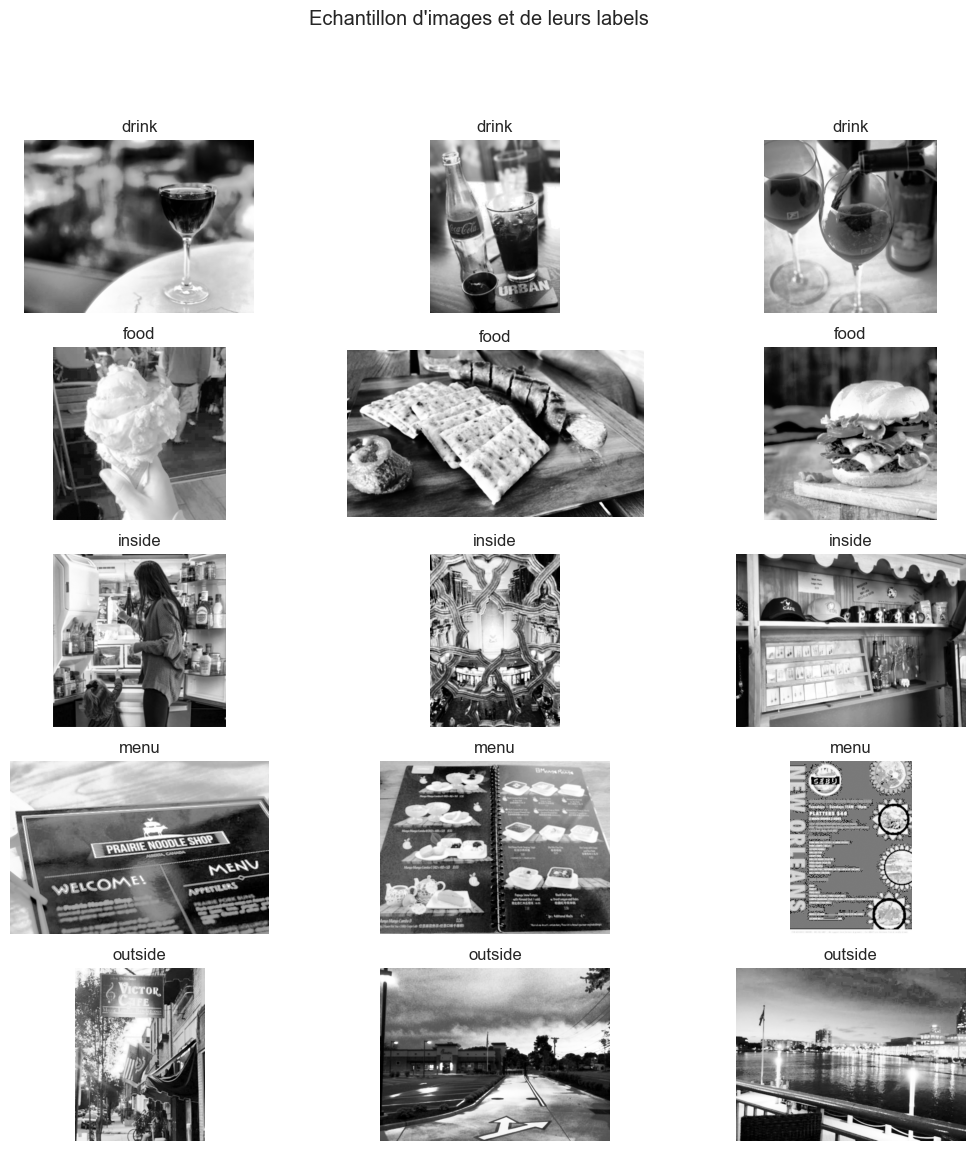

In [ ]:
def show_image_label(image, label):
    """
    Affiche une image avec son label.
    Args:
        image (numpy.ndarray): Image à afficher.
        label (str): Label à utiliser comme titre de l'image.
    """
    plt.imshow(image, "gray")
    plt.axis("off")
    plt.title(label)


# Liste des indices des images à afficher
img_indices = [0, 1, 2, 201, 202, 203, 401, 402, 403, 601, 602, 603, 801, 802, 803]
plt.figure(figsize=(13, 13))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    show_image_label(images[img_indices[i]], labels[img_indices[i]])
plt.suptitle("Echantillon d'images et de leurs labels")

### Extraction de features : SIFT


In [ ]:
%%time


def extract_features_sift(img):
    """
    Extrait les descripteurs de caractéristiques SIFT d'une image.

    Args:
        img (numpy.ndarray): L'image à partir de laquelle les caractéristiques doivent être extraites.

    Returns:
        des (numpy.ndarray): Le descripteur SIFT pour l'image.
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des


# Extraire les caractéristiques de toutes les images
sift_keypoints = []
for img in images:
    sift_keypoints.append(extract_features_sift(img))
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

CPU times: total: 3min 53s
Wall time: 1min 6s


Calculer le ARI pour cette partie  autour de 5%

In [ ]:
print("Nombres de descripteurs :", sift_keypoints_all.shape)

Nombres de descripteurs : (1595173, 128)


Nous allons utiliser la racine carré du nombre de descripteurs comme nombre de clusters afin de regrouper uniquement les descripteurs qui sont les plus proches et obtenir un nombre maximal de clusters possibles pour les descripteurs.
Une autre méthode est de prendre le nombre de catégories que l'on veut traiter et le multiplier par 10 pour obtenir le nombre minimal de clusters possibles pour les descripteurs.


In [ ]:
k = int(round(np.sqrt(len(sift_keypoints_all))))
# k = df_images.label.nunique() * 10
print("Création de", k, "clusters de descripteurs")

Création de 1263 clusters de descripteurs


In [ ]:
%%time
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

CPU times: total: 2min 40s
Wall time: 46.8 s


MiniBatchKMeans(n_clusters=1263, random_state=0)

Nous allons transformer chaque image en un vecteur de caractéristiques qui décrit la distribution de ses descripteurs SIFT sur les clusters k-means.


In [ ]:
def build_histogram(kmeans, des, image_num):
    """
    Construit un histogramme des descripteurs SIFT en utilisant le clustering k-means.

    Args:
        kmeans (sklearn.cluster.KMeans): Le modèle k-means utilisé pour le clustering.
        des (numpy.ndarray): Le descripteur SIFT de l'image.
        image_num (int): Le numéro de l'image (utilisé pour l'itération des images').

    Returns:
        hist (numpy.ndarray): L'histogramme des descripteurs SIFT.
    """
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problèmes histogramme image")
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

Si l'ensemble de données est de grande dimension, il est recommandé de procéder à une analyse en composantes principales, faute de quoi la malédiction de la dimensionnalité peut poser problème. La TSNE part de l'hypothèse d'une linéarité locale qui peut ne pas être valable en haute dimension, où le collecteur peut varier, et l'ACP peut aider à résoudre ce problème en réduisant la dimensionnalité des données. Pour le nombre de composantes, nous fixerons sont nombre afin de conserver une variance totale de 95%.


In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 495)


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1000, 3)


clustering // vérification similarité

- indices de rand
- features peuvent


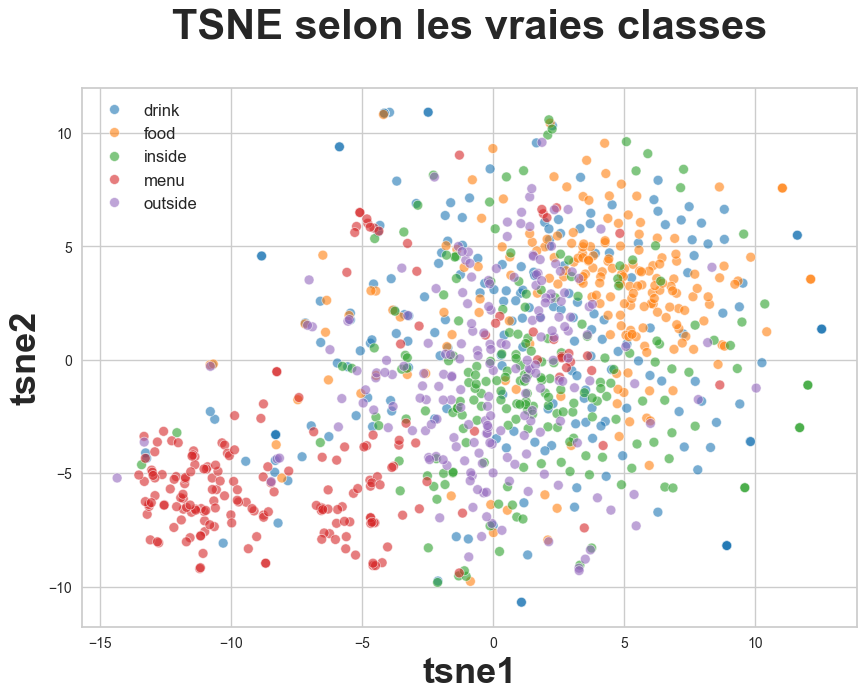

In [ ]:
palette = sns.color_palette("tab10", n_colors=5)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [ ]:
cls = KMeans(n_clusters=5, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
display(df_tsne.head())

tsne1     tsne2  class  cluster
0 -0.110743  8.404478  drink        0
1  6.300572 -6.720824  drink        1
2  5.558578 -0.057318  drink        2
3 -8.842628  4.567367  drink        4
4  3.013505 -0.487140  drink        2

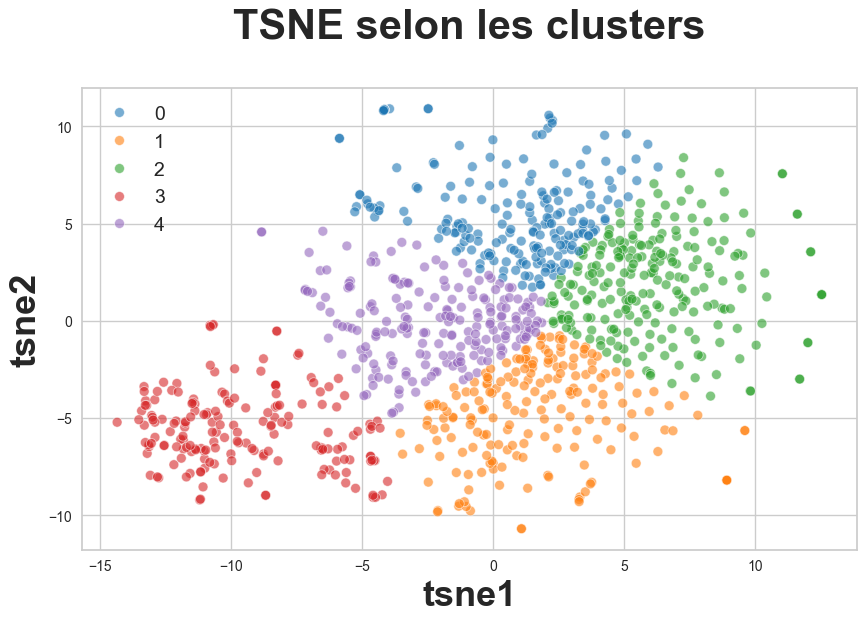

ARI :  0.1711037572264386


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 14})

plt.show()

print("ARI : ", adjusted_rand_score(labels, cls.labels_))

In [ ]:
df_tsne.cluster.value_counts()

cluster
2    229
4    201
0    198
1    192
3    180
Name: count, dtype: int64

In [ ]:
def confusion(y_test, y_pred):
    """
    Génère une matrice de confusion sous forme de DataFrame Pandas.

    Args:
        y_test (list or np.array): Les valeurs réelles de y.
        y_pred (list or np.array): Les valeurs prédites de y.

    Returns:
        mat (pd.DataFrame): La matrice de confusion.
    """
    list_labels = ["drink", "food", "inside", "menu", "outside"]
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [i for i in mat.columns]
    mat.index = [i for i in list_labels]
    return mat

In [ ]:
labels_encoded = LabelEncoder().fit_transform(labels)
conf_mat_sift = confusion(labels_encoded, cls.labels_)

Text(0.5, 1.0, 'Matrice de confusion')

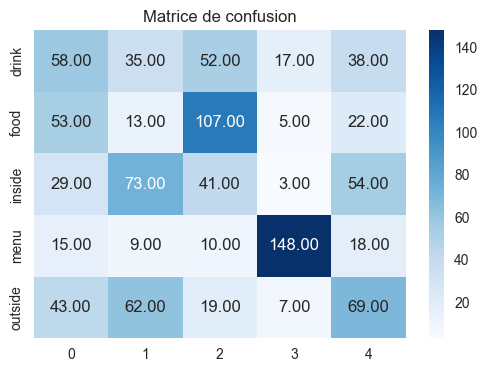

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_sift, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

vgg meilleures


In [ ]:
class Sampler(BaseEstimator, TransformerMixin):
    """
    Cette classe est utilisée pour échantillonner un nombre spécifique d'échantillons pour chaque label du jeu de données.
    """

    def __init__(self, n_samples_per_label):
        self.n_samples_per_label = n_samples_per_label

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.groupby("label").sample(n=self.n_samples_per_label, random_state=6)


class ImageLoader(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour charger les images à partir d'un répertoire spécifié.
    """

    def __init__(self, input_dir):
        self.input_dir = input_dir

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        image_paths = []
        for index, row in X.iterrows():
            # Obtenir l'ID de l'image
            image_id = row["photo_id"]
            # Obtenir le chemin de l'image
            image_path = os.path.join(self.input_dir, f"{image_id}.jpg")
            image_paths.append(image_path)
        return image_paths


class ImagePreprocessor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour prétraiter les images.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        for image_path in X:
            preprocessed_images.append(preprocess_image(image_path))
        return preprocessed_images


class SiftFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour extraire les caractéristiques des images en utilisant l'algorithme SIFT
    et pour créer un histogramme des features à l'aide de l'algorithme KMeans.
    """

    def __init__(self):
        self.kmeans = None

    def fit(self, X, y=None):
        # Extraire les caractéristiques de toutes les images
        sift_keypoints = []
        for img in X:
            sift_keypoints.append(extract_features_sift(img))
        sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
        n_clusters = int(round(np.sqrt(len(sift_keypoints_all))))
        # Former le modèle KMeans
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(sift_keypoints_all)
        return self

    def transform(self, X):
        hist_vectors = []
        for img in X:
            des = extract_features_sift(img)
            hist = self.build_histogram(des)
            hist_vectors.append(hist)
        return np.asarray(hist_vectors)

    def build_histogram(self, des):
        res = self.kmeans.predict(des)
        hist = np.zeros(len(self.kmeans.cluster_centers_))
        nb_des = len(des)
        if nb_des == 0:
            print("problèmes histogramme image")
        for i in res:
            hist[i] += 1.0 / nb_des
        return hist


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", SiftFeatureExtractor()),
    ]
)

hist_vectors = image_processing_pipeline.fit_transform(df_images)

In [ ]:
print(hist_vectors)
print(hist_vectors.shape)

[[0.         0.         0.00363636 ... 0.01090909 0.         0.00363636]
 [0.00169492 0.00338983 0.00338983 ... 0.00677966 0.00338983 0.        ]
 [0.         0.0115942  0.0057971  ... 0.0115942  0.00289855 0.        ]
 ...
 [0.00105597 0.00598381 0.00246392 ... 0.0031679  0.0031679  0.00070398]
 [0.00062189 0.00062189 0.00808458 ... 0.00497512 0.00373134 0.00124378]
 [0.         0.00182315 0.00091158 ... 0.00729262 0.00273473 0.00455789]]
(50, 264)


In [ ]:
def extract_features_vgg(images):
    """
    Extrait des caractéristiques à partir d'un ensemble d'images en utilisant le modèle pré-entraîné VGG16.

    Args:
        images (liste de ndarray): liste d'images à partir desquelles extraire les caractéristiques.
        Chaque élément de la liste doit être un tableau numpy représentant une image.

    Returns:
        ndarray: tableau numpy de caractéristiques extraites.
        Chaque ligne correspond à une image et chaque colonne à une caractéristique.
    """
    model = VGG16(weights="imagenet", include_top=False)
    features_vgg16 = []

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_size = (224, 224)
        img = cv2.resize(img, img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        features_vgg16.append(features)
    features_vgg16 = np.asarray(features_vgg16)

    return features_vgg16

features_vgg = extract_features_vgg(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
features_vgg_flattened = features_vgg.reshape((1000, -1))

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(features_vgg_flattened)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 799)


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1000, 3)


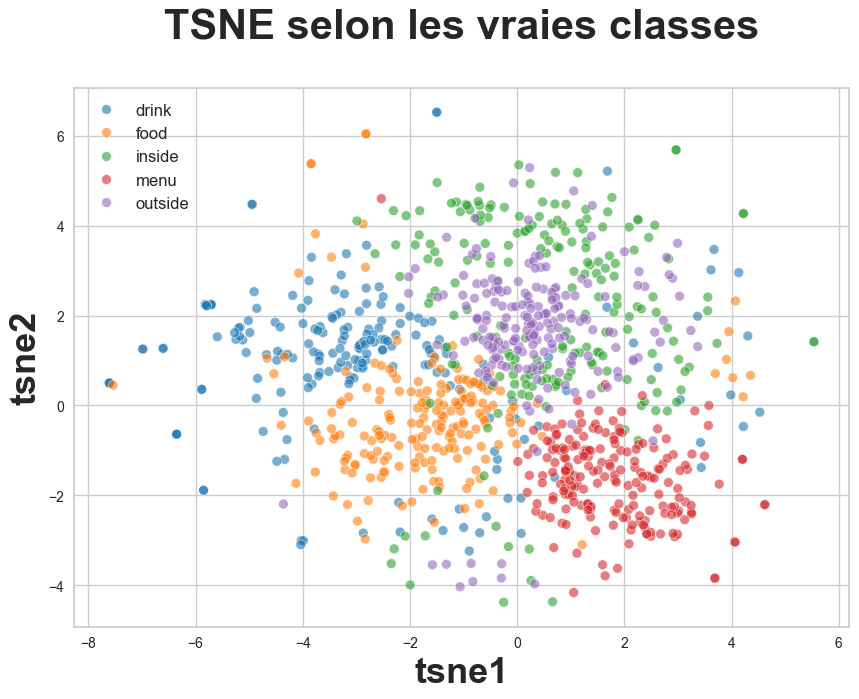

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feat_pca)
df_tsne["cluster"] = kmeans.labels_
ari_score = adjusted_rand_score(labels_encoded, kmeans.labels_)
print("ARI : ", ari_score)

ARI :  0.31076557709774133


Text(0.5, 1.0, 'Matrice de confusion')

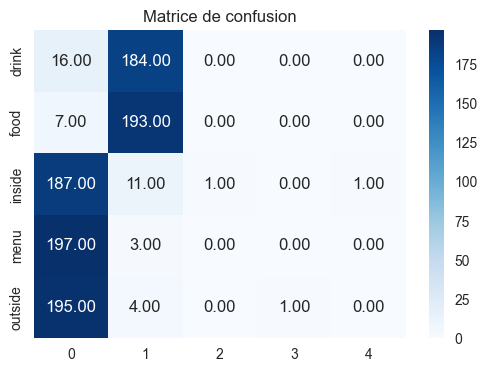

In [ ]:
conf_mat_vgg = confusion(labels_encoded, kmeans.labels_)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_vgg, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

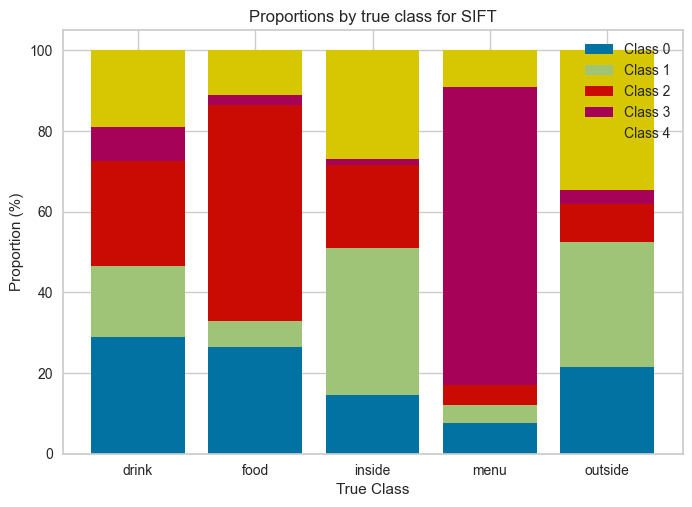

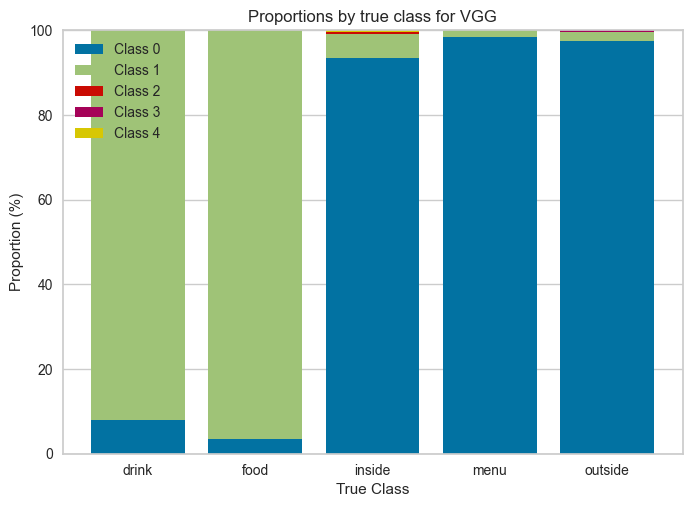

In [ ]:
def plot_stacked_bar(df, title):
    """
    Trace un diagramme à barres empilées à partir d'un DataFrame pour visualiser les proportions de classes prédites pour chaque
    classe réelle dans un problème de classification.

    Args:
        df (DataFrame): DataFrame à partir duquel le graphique est tracé.
                        Les lignes correspondent aux classes réelles et les colonnes aux classes prédites.
        title (str)   : Titre du graphique.
    """
    df = df.div(df.sum(axis=1), axis=0) * 100
    labels = df.index
    num_labels = len(labels)
    x = np.arange(num_labels)

    fig, ax = plt.subplots()
    for i in range(df.shape[1]):
        if i == 0:
            ax.bar(x, df.iloc[:, i], label="Class " + str(i))
        else:
            ax.bar(
                x,
                df.iloc[:, i],
                bottom=df.iloc[:, :i].sum(axis=1),
                label="Class " + str(i),
            )

    ax.set_xlabel("True Class")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"Proportions by true class for {title}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

plot_stacked_bar(conf_mat_sift, "SIFT")
plot_stacked_bar(conf_mat_vgg, "VGG")

In [ ]:
class VGGFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui utilise le modèle VGG16 pour extraire les caractéristiques des images.
    """

    def __init__(self):
        self.model = VGG16(weights="imagenet", include_top=False)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features_vgg16 = []

        for img in X:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_size = (224, 224)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)

            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            features = self.model.predict(img_array)
            features_vgg16.append(features)

        return np.asarray(features_vgg16)


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", VGGFeatureExtractor()),
    ]
)

vgg_features = image_processing_pipeline.fit_transform(df_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
df_tsne.cluster.value_counts()

cluster
2    229
4    201
0    198
1    192
3    180
Name: count, dtype: int64

In [ ]:
def confusion(y_test, y_pred):
    """
    Génère une matrice de confusion sous forme de DataFrame Pandas.

    Args:
        y_test (list or np.array): Les valeurs réelles de y.
        y_pred (list or np.array): Les valeurs prédites de y.

    Returns:
        mat (pd.DataFrame): La matrice de confusion.
    """
    list_labels = ["drink", "food", "inside", "menu", "outside"]
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [i for i in mat.columns]
    mat.index = [i for i in list_labels]
    return mat

In [ ]:
labels_encoded = LabelEncoder().fit_transform(labels)
conf_mat_sift = confusion(labels_encoded, cls.labels_)

Text(0.5, 1.0, 'Matrice de confusion')

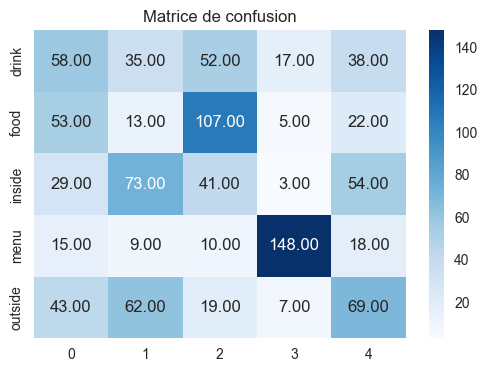

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_sift, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

In [ ]:
class Sampler(BaseEstimator, TransformerMixin):
    """
    Cette classe est utilisée pour échantillonner un nombre spécifique d'échantillons pour chaque label du jeu de données.
    """

    def __init__(self, n_samples_per_label):
        self.n_samples_per_label = n_samples_per_label

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.groupby("label").sample(n=self.n_samples_per_label, random_state=6)


class ImageLoader(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour charger les images à partir d'un répertoire spécifié.
    """

    def __init__(self, input_dir):
        self.input_dir = input_dir

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        image_paths = []
        for index, row in X.iterrows():
            # Obtenir l'ID de l'image
            image_id = row["photo_id"]
            # Obtenir le chemin de l'image
            image_path = os.path.join(self.input_dir, f"{image_id}.jpg")
            image_paths.append(image_path)
        return image_paths


class ImagePreprocessor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour prétraiter les images.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        for image_path in X:
            preprocessed_images.append(preprocess_image(image_path))
        return preprocessed_images


class SiftFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour extraire les caractéristiques des images en utilisant l'algorithme SIFT
    et pour créer un histogramme des features à l'aide de l'algorithme KMeans.
    """

    def __init__(self):
        self.kmeans = None

    def fit(self, X, y=None):
        # Extraire les caractéristiques de toutes les images
        sift_keypoints = []
        for img in X:
            sift_keypoints.append(extract_features_sift(img))
        sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
        n_clusters = int(round(np.sqrt(len(sift_keypoints_all))))
        # Former le modèle KMeans
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(sift_keypoints_all)
        return self

    def transform(self, X):
        hist_vectors = []
        for img in X:
            des = extract_features_sift(img)
            hist = self.build_histogram(des)
            hist_vectors.append(hist)
        return np.asarray(hist_vectors)

    def build_histogram(self, des):
        res = self.kmeans.predict(des)
        hist = np.zeros(len(self.kmeans.cluster_centers_))
        nb_des = len(des)
        if nb_des == 0:
            print("problèmes histogramme image")
        for i in res:
            hist[i] += 1.0 / nb_des
        return hist


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", SiftFeatureExtractor()),
    ]
)

hist_vectors = image_processing_pipeline.fit_transform(df_images)

In [ ]:
cls = KMeans(n_clusters=5, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
display(df_tsne.head())

tsne1     tsne2  class  cluster
0 -0.110743  8.404478  drink        0
1  6.300572 -6.720824  drink        1
2  5.558578 -0.057318  drink        2
3 -8.842628  4.567367  drink        4
4  3.013505 -0.487140  drink        2

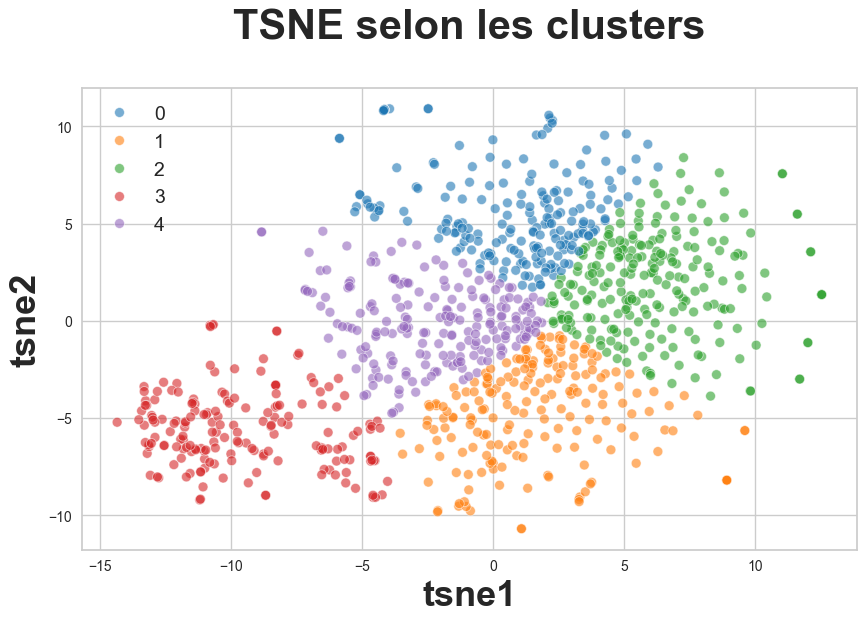

ARI :  0.1711037572264386


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 14})

plt.show()

print("ARI : ", adjusted_rand_score(labels, cls.labels_))

In [ ]:
df_tsne.cluster.value_counts()

cluster
2    229
4    201
0    198
1    192
3    180
Name: count, dtype: int64

In [ ]:
def confusion(y_test, y_pred):
    """
    Génère une matrice de confusion sous forme de DataFrame Pandas.

    Args:
        y_test (list or np.array): Les valeurs réelles de y.
        y_pred (list or np.array): Les valeurs prédites de y.

    Returns:
        mat (pd.DataFrame): La matrice de confusion.
    """
    list_labels = ["drink", "food", "inside", "menu", "outside"]
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [i for i in mat.columns]
    mat.index = [i for i in list_labels]
    return mat

In [ ]:
labels_encoded = LabelEncoder().fit_transform(labels)
conf_mat_sift = confusion(labels_encoded, cls.labels_)

Text(0.5, 1.0, 'Matrice de confusion')

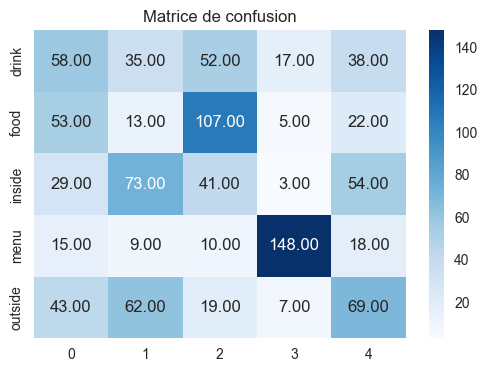

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_sift, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

#### Enchainement des étapes de nettoyage et de création de variables (SIFT)


In [ ]:
class Sampler(BaseEstimator, TransformerMixin):
    """
    Cette classe est utilisée pour échantillonner un nombre spécifique d'échantillons pour chaque label du jeu de données.
    """

    def __init__(self, n_samples_per_label):
        self.n_samples_per_label = n_samples_per_label

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.groupby("label").sample(n=self.n_samples_per_label, random_state=6)


class ImageLoader(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour charger les images à partir d'un répertoire spécifié.
    """

    def __init__(self, input_dir):
        self.input_dir = input_dir

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        image_paths = []
        for index, row in X.iterrows():
            # Obtenir l'ID de l'image
            image_id = row["photo_id"]
            # Obtenir le chemin de l'image
            image_path = os.path.join(self.input_dir, f"{image_id}.jpg")
            image_paths.append(image_path)
        return image_paths


class ImagePreprocessor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour prétraiter les images.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        for image_path in X:
            preprocessed_images.append(preprocess_image(image_path))
        return preprocessed_images


class SiftFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur personnalisé est utilisée pour extraire les caractéristiques des images en utilisant l'algorithme SIFT
    et pour créer un histogramme des features à l'aide de l'algorithme KMeans.
    """

    def __init__(self):
        self.kmeans = None

    def fit(self, X, y=None):
        # Extraire les caractéristiques de toutes les images
        sift_keypoints = []
        for img in X:
            sift_keypoints.append(extract_features_sift(img))
        sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
        n_clusters = int(round(np.sqrt(len(sift_keypoints_all))))
        # Former le modèle KMeans
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(sift_keypoints_all)
        return self

    def transform(self, X):
        hist_vectors = []
        for img in X:
            des = extract_features_sift(img)
            hist = self.build_histogram(des)
            hist_vectors.append(hist)
        return np.asarray(hist_vectors)

    def build_histogram(self, des):
        res = self.kmeans.predict(des)
        hist = np.zeros(len(self.kmeans.cluster_centers_))
        nb_des = len(des)
        if nb_des == 0:
            print("problèmes histogramme image")
        for i in res:
            hist[i] += 1.0 / nb_des
        return hist


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", SiftFeatureExtractor()),
    ]
)

hist_vectors = image_processing_pipeline.fit_transform(df_images)

In [ ]:
print(hist_vectors)
print(hist_vectors.shape)

[[0.         0.         0.00363636 ... 0.01090909 0.         0.00363636]
 [0.00169492 0.00338983 0.00338983 ... 0.00677966 0.00338983 0.        ]
 [0.         0.0115942  0.0057971  ... 0.0115942  0.00289855 0.        ]
 ...
 [0.00105597 0.00598381 0.00246392 ... 0.0031679  0.0031679  0.00070398]
 [0.00062189 0.00062189 0.00808458 ... 0.00497512 0.00373134 0.00124378]
 [0.         0.00182315 0.00091158 ... 0.00729262 0.00273473 0.00455789]]
(50, 264)


Nous obtenons bien une représentation vectorielle pour chacune de nos images, obtenue grâce à la méthode SIFT et au clustering.


### VGG-16


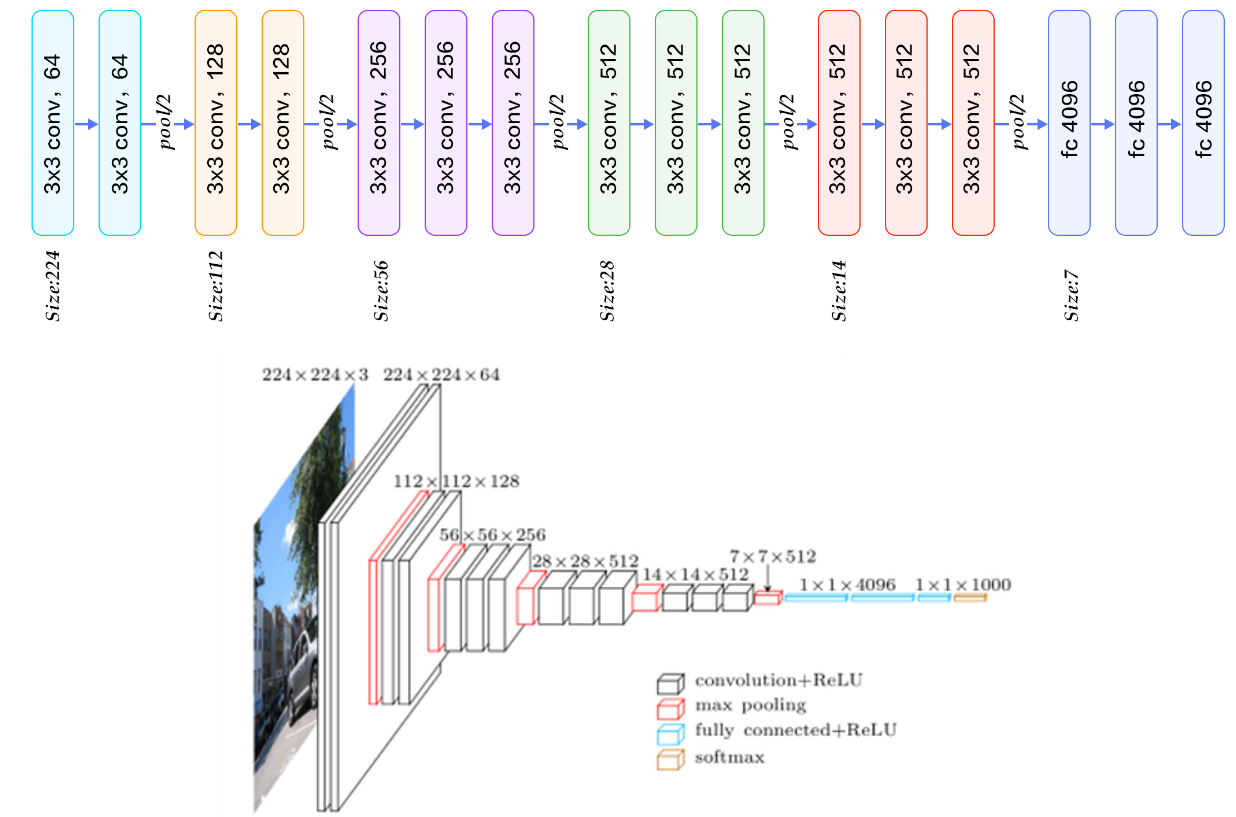

- **Performance**: VGG-16 a démontré une performance exceptionnelle sur l'ensemble de données ImageNet et continue d'être un choix populaire pour la tâche d'extraction de caractéristiques malgré l'existence de modèles plus récents et potentiellement plus performants. Il peut capturer des caractéristiques complexes à partir d'images de manière efficace.

- **Architecture simple**: VGG-16 a une architecture simple et intuitive composée uniquement de couches de convolution 3x3 et de couches max pooling. Cela le rend facile à comprendre et à utiliser. De plus, malgré sa simplicité, VGG-16 est capable d'extraire des caractéristiques très informatives.

- **Généralisation**: VGG-16 a une excellente capacité de généralisation, ce qui signifie qu'il est capable de bien fonctionner sur une grande variété de tâches et de types de données différents.

- **Pré-entraînement sur ImageNet**: VGG-16 a été pré-entraîné sur l'ensemble de données ImageNet, qui contient plus de 14 millions d'images annotées et couvre une large gamme de catégories d'objets. Cela signifie que le modèle a déjà appris à reconnaître une grande variété de caractéristiques d'images, ce qui peut être très utile pour l'extraction de caractéristiques.


In [ ]:
def extract_features_vgg(images):
    """
    Extrait des caractéristiques à partir d'un ensemble d'images en utilisant le modèle pré-entraîné VGG16.

    Args:
        images (liste de ndarray): liste d'images à partir desquelles extraire les caractéristiques.
        Chaque élément de la liste doit être un tableau numpy représentant une image.

    Returns:
        ndarray: tableau numpy de caractéristiques extraites.
        Chaque ligne correspond à une image et chaque colonne à une caractéristique.
    """
    model = VGG16(weights="imagenet", include_top=False)
    features_vgg16 = []

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_size = (224, 224)
        img = cv2.resize(img, img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        features_vgg16.append(features)
    features_vgg16 = np.asarray(features_vgg16)
    
    return features_vgg16

In [ ]:
def extract_features_vgg(images):
    """
    Extrait des caractéristiques à partir d'un ensemble d'images en utilisant le modèle pré-entraîné VGG16.

    Args:
        images (liste de ndarray): liste d'images à partir desquelles extraire les caractéristiques.
        Chaque élément de la liste doit être un tableau numpy représentant une image.

    Returns:
        ndarray: tableau numpy de caractéristiques extraites.
        Chaque ligne correspond à une image et chaque colonne à une caractéristique.
    """
    model = VGG16(weights="imagenet", include_top=False)
    features_vgg16 = []

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_size = (224, 224)
        img = cv2.resize(img, img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array)
        features_vgg16.append(features)
    features_vgg16 = np.asarray(features_vgg16)

    return features_vgg16


features_vgg = extract_features_vgg(images)

In [ ]:
features_vgg = extract_features_vgg(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

sauvegarde


In [ ]:
dump(features_vgg, 'features_vgg.joblib')

['features_vgg.joblib']

recharge


In [ ]:
features_vgg = load('features_vgg.joblib')

In [ ]:
features_vgg_flattened = features_vgg.reshape((1000, -1))

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(features_vgg_flattened)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 818)
(1000, 3)


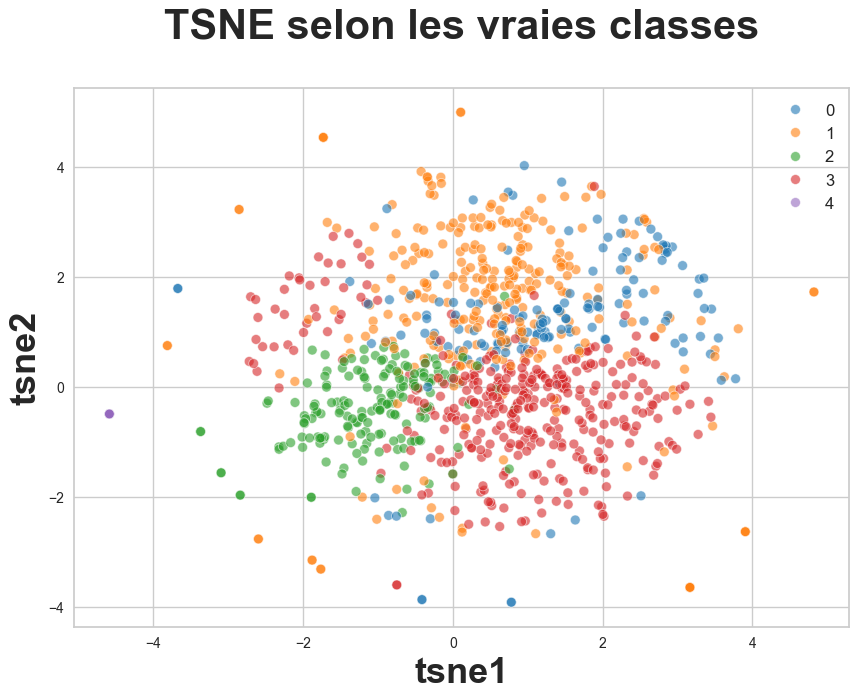

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [ ]:
# Supposons que vous ayez déjà extrait les caractéristiques et que 'features_vgg_flattened' soit défini.  
# features_vgg_flattened = extract_features_vgg(images)   

# Inspecter les données pour trouver des NaN ou des valeurs infinies.  
print("Nombre de NaN dans les données :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies dans les données :", np.sum(np.isinf(features_vgg_flattened)))  

# Identifier les indices contenant des NaN et des valeurs infinies  
nan_indices = np.where(np.isnan(features_vgg_flattened))  
inf_indices = np.where(np.isinf(features_vgg_flattened))  
print(f"Indices NaN : {nan_indices}")  
print(f"Indices Inf : {inf_indices}")  

# Nettoyer les données  
# Remplacer les NaN par la moyenne des colonnes  
mean_values = np.nanmean(features_vgg_flattened, axis=0)  
for i in range(features_vgg_flattened.shape[1]):  
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = mean_values[i]  

# Remplacer les valeurs infinies par la moyenne des colonnes  
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)  

# Vérification finale des données après nettoyage  
print("Vérification finale des données :")  
print("Nombre de NaN dans les données après nettoyage :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies dans les données après nettoyage :", np.sum(np.isinf(features_vgg_flattened)))  

# Vérifiez que les dimensions sont correctes  
if features_vgg_flattened.ndim != 2:  
    raise ValueError("Les données doivent être un tableau 2D avec la forme (n_samples, n_features).")  

print("Dimensions des données après nettoyage :", features_vgg_flattened.shape)  

# Exécutez KMeans  
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=2)  
kmeans.fit(features_vgg_flattened)  

# Récupérer les étiquettes de clusters  
labels = kmeans.labels_  
print("Cluster labels:", labels)  

# Optionnel : si vous avez des étiquettes connues, vous pouvez évaluer la qualité du clustering  
# labels_encoded = ...  # Remplacez par vos étiquettes connues si nécessaire  
# ari_score = adjusted_rand_score(labels_encoded, labels)  
# print(f"ARI Score: {ari_score}")  

Nombre de NaN dans les données : 0
Nombre de valeurs infinies dans les données : 0
Indices NaN : (array([], dtype=int64), array([], dtype=int64))
Indices Inf : (array([], dtype=int64), array([], dtype=int64))
Vérification finale des données :
Nombre de NaN dans les données après nettoyage : 0
Nombre de valeurs infinies dans les données après nettoyage : 0
Dimensions des données après nettoyage : (1000, 25088)


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


ValueError: cannot convert float NaN to integer

In [ ]:
# Supposons que 'features_vgg_flattened' a été obtenu précédemment  

# Étape 1 : Inspecter les données  
print("Nombre de NaN dans les données :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies dans les données :", np.sum(np.isinf(features_vgg_flattened)))  

# Étape 2 : Identifier les valeurs NaN ou infinies  
nan_indices = np.where(np.isnan(features_vgg_flattened))  
inf_indices = np.where(np.isinf(features_vgg_flattened))  
print(f"Indices NaN : {nan_indices}")  
print(f"Indices Inf : {inf_indices}")  

# Étape 3 : Nettoyer les données  
# Remplacer les NaN par la moyenne des colonnes  
mean_values = np.nanmean(features_vgg_flattened)

SyntaxError: incomplete input (3384069460.py, line 15)

In [ ]:

# Étape 1 : Vérifiez la présence de valeurs NaN et infinies  
if np.isnan(features_vgg_flattened).any() or np.isinf(features_vgg_flattened).any():  
    print("Des valeurs NaN ou infinies ont été détectées dans les données.")  
    
    # Remplacer les NaN par la moyenne des colonnes  
    features_vgg_flattened = np.nan_to_num(features_vgg_flattened, nan=np.nanmean(features_vgg_flattened))  
    
    # Remplacer les valeurs infinies par la moyenne des colonnes  
    features_vgg_flattened = np.where(np.isinf(features_vgg_flattened), np.nanmean(features_vgg_flattened), features_vgg_flattened)  

# Étape 2 : Vérifiez le format des données  
if features_vgg_flattened.ndim != 2:  
    raise ValueError("Les données doivent être un tableau 2D avec la forme (n_samples, n_features).")  

print("Dimensions des données après nettoyage :", features_vgg_flattened.shape)  

# Étape 3 : Exécutez KMeans  
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  
kmeans.fit(features_vgg_flattened)  

# Étape 4 : Récupérer les étiquettes de clusters  
labels = kmeans.labels_  
print("Cluster labels:", labels)  

Dimensions des données après nettoyage : (1000, 25088)


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


ValueError: cannot convert float NaN to integer

detection des NaN


In [ ]:
# Vérifiez s'il y a des NaN ou des valeurs infinies  
if np.isnan(features_vgg_flattened).any() or np.isinf(features_vgg_flattened).any():  
    print("Des valeurs NaN ou infinies ont été détectées dans les données.")  

In [ ]:
# Remplacer des NaN par la moyenne des colonnes  
features_vgg_flattened = np.nan_to_num(features_vgg_flattened, nan=np.nanmean(features_vgg_flattened))  

# Remplacer les valeurs infinies par la valeur maximale de la colonne (ou une autre méthode)  
features_vgg_flattened = np.where(np.isinf(features_vgg_flattened), np.nanmean(features_vgg_flattened), features_vgg_flattened)  

In [ ]:
from sklearn.cluster import KMeans  
from sklearn.metrics import adjusted_rand_score  

# Supposons que vous ayez déjà extrait les caractéristiques et que 'features_vgg_flattened' est défini  
# features_vgg_flattened = extract_features_vgg(images)  # Exemple d'extraction  

# Étape 1 : Vérifiez la présence de valeurs NaN  
if np.isnan(features_vgg_flattened).any():  
    print("Des valeurs NaN ont été détectées dans les données.")  
    
    # Étape 2 : Affichez le nombre de NaN et remplacez-les  
    print(f"Nombre de valeurs NaN : {np.sum(np.isnan(features_vgg_flattened))}")  
    
    # Remplacer les NaN par la moyenne des colonnes  
    features_vgg_flattened = np.nan_to_num(features_vgg_flattened, nan=np.nanmean(features_vgg_flattened))  

# Étape 3 : Vérifiez le format des données  
if features_vgg_flattened.ndim != 2:  
    raise ValueError("Les données doivent être un tableau 2D avec la forme (n_samples, n_features).")  

print("Dimensions des données :", features_vgg_flattened.shape)  

# Étape 4 : Exécutez KMeans  
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  
kmeans.fit(features_vgg_flattened)  

# Étape 5 : Récupérer les étiquettes de clusters  
labels = kmeans.labels_  

# Si vous avez des étiquettes connues, vous pouvez calculer le score ARI  
# labels_encoded = ...  # Remplacez par vos étiquettes connues si nécessaire  
# ari_score = adjusted_rand_score(labels_encoded, labels)  
# print(f"ARI Score: {ari_score}")  

# Ajouter les résultats au DataFrame (si vous avez un DataFrame df_tsne)  
# df_tsne["cluster"] = labels  
# print(df_tsne.head())  

print("Cluster labels:", labels)  

Dimensions des données : (1000, 25088)


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


ValueError: cannot convert float NaN to integer

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95, random_state=0)
feat_pca = pca.fit_transform(features_vgg_flattened)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init="random", random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = labels
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (1000, 1263)
Dimensions dataset après réduction PCA :  (1000, 818)
(1000, 3)


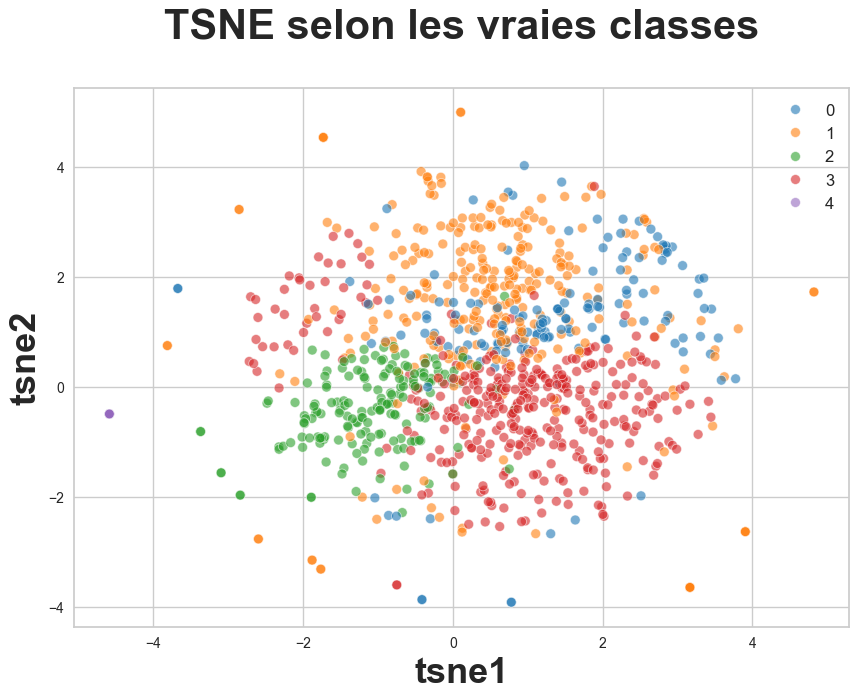

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="class",
    data=df_tsne,
    legend="brief",
    palette=palette,
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les vraies classes", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 12})

plt.show()

In [ ]:
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.metrics import adjusted_rand_score  

# Supposons que features_vgg_flattened soit déjà défini  
# Vérifiez la présence de NaN et d'infini  
print("Avant nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  

# Identifier les indices contenant des NaN  
nan_indices = np.where(np.isnan(features_vgg_flattened))  
inf_indices = np.where(np.isinf(features_vgg_flattened))  

# Nettoyage des données  
# 1. Remplacer NaN par la moyenne de chaque colonne  
means = np.nanmean(features_vgg_flattened, axis=0)  
for i in range(features_vgg_flattened.shape[1]):  
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = means[i]  

# 2. Remplacer les valeurs infinies par la moyenne de chaque colonne  
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)  

# Vérification après nettoyage  
print("Après nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  

# Vérifiez si les données sont toujours correctes  
if features_vgg_flattened.ndim != 2:  
    raise ValueError("Les données doivent être un tableau 2D avec la forme (n_samples, n_features).")  

print("Dimensions des données après nettoyage :", features_vgg_flattened.shape)  

# Étape 2 : Exécution de KMeans  
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  

# Essayez de vous adapter à l'exception si quelque chose échoue à ce stade  
try:  
    kmeans.fit(features_vgg_flattened)  
    labels = kmeans.labels_  
    print("Cluster labels:", labels)  
except ValueError as e:  
    print("Une erreur s'est produite lors de l'exécution de KMeans :", e)  

Avant nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Après nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Dimensions des données après nettoyage : (1000, 25088)
Une erreur s'est produite lors de l'exécution de KMeans : cannot convert float NaN to integer


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Supposons que features_vgg_flattened soit déjà défini
print("Avant nettoyage :")
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))

# Vérification des types de données
print("Type des données :", features_vgg_flattened.dtype)

# S'assurer que tout est de type float
if not np.issubdtype(features_vgg_flattened.dtype, np.floating):
    features_vgg_flattened = features_vgg_flattened.astype(float)

# Vérification après conversion de type
print("Type des données après conversion :", features_vgg_flattened.dtype)

# Nettoyer les données une fois de plus (au cas où)
means = np.nanmean(features_vgg_flattened, axis=0)
for i in range(features_vgg_flattened.shape[1]):
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = means[i]
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)

print("Après nettoyage :")
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))
print("Dimensions des données après nettoyage :", features_vgg_flattened.shape)

# Exécution de KMeans
n_clusters = 5
try:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++')
    kmeans.fit(features_vgg_flattened)
    labels = kmeans.labels_
    print("Cluster labels:", labels)
except ValueError as e:
    print("Une erreur s'est produite lors de l'exécution de KMeans :", e)

Avant nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Type des données : float32
Type des données après conversion : float32
Après nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Dimensions des données après nettoyage : (1000, 25088)
Une erreur s'est produite lors de l'exécution de KMeans : cannot convert float NaN to integer


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


In [ ]:
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.metrics import adjusted_rand_score  

# Supposons que features_vgg_flattened soit déjà défini  
# Exemple : features_vgg_flattened = extract_features_vgg(images)  

# Étape 1: Vérification de la présence de NaN et d'infini  
print("Avant nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  

# Étape 2: Vérification des types de données  
print("Type des données :", features_vgg_flattened.dtype)  

# S'assurer que tout est de type float  
if not np.issubdtype(features_vgg_flattened.dtype, np.floating):  
    features_vgg_flattened = features_vgg_flattened.astype(float)  

# Vérifier les dimensions des données  
print("Dimensions des données :", features_vgg_flattened.shape)  

# Vérification finale des valeurs uniques pour s'assurer qu'il n'y a pas de problèmes  
unique_values = np.unique(features_vgg_flattened)  
print("Valeurs uniques dans les données (exemple):", unique_values[:10])  # Montre un échantillon des valeurs uniques  

# Étape 3: Nettoyage des données  
# Remplacer les NaN par la moyenne des colonnes  
means = np.nanmean(features_vgg_flattened, axis=0)  
for i in range(features_vgg_flattened.shape[1]):  
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = means[i]  

# Remplacer les valeurs infinies par la moyenne des colonnes  
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)  

# Vérification des données après nettoyage  
print("Après nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  
print("Dimensions des données après nettoyage :", features_vgg_flattened.shape)  

# Étape 4: Exécution de KMeans  
n_clusters = 5  
try:  
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init=10, verbose=1)  
    kmeans.fit(features_vgg_flattened)  
    labels = kmeans.labels_  
    print("Cluster labels:", labels)  
except ValueError as e:  
    print("Une erreur s'est produite lors de l'exécution de KMeans :", e)  
except Exception as e:  
    print("Une autre erreur s'est produite :", e)  

Avant nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Type des données : float32
Dimensions des données : (1000, 25088)
Valeurs uniques dans les données (exemple): [-0.0000000e+00  3.1739473e-06  5.3048134e-06  6.5267086e-06
  1.2040138e-05  3.1854957e-05  3.3766031e-05  4.7914684e-05
  5.3614378e-05  6.3300133e-05]
Après nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Dimensions des données après nettoyage : (1000, 25088)
Une erreur s'est produite lors de l'exécution de KMeans : cannot convert float NaN to integer


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


In [ ]:
import numpy as np  
from sklearn.cluster import DBSCAN  
from sklearn.preprocessing import StandardScaler  

# Supposons que features_vgg_flattened soit déjà défini  
print("Avant nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  

# Vérification des types de données  
if not np.issubdtype(features_vgg_flattened.dtype, np.floating):  
    features_vgg_flattened = features_vgg_flattened.astype(float)  

# Nettoyage des données  
means = np.nanmean(features_vgg_flattened, axis=0)  
for i in range(features_vgg_flattened.shape[1]):  
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = means[i]  
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)  

# Standardisation des données  
features_vgg_flattened = StandardScaler().fit_transform(features_vgg_flattened)  

# Exécution de DBSCAN  
epsilon = 0.5  # Distance maximale pour considérer deux points dans un même voisinage  
min_samples = 5  # Nombre minimum de points dans un voisinage pour former un cluster  
try:  
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)  
    labels = dbscan.fit_predict(features_vgg_flattened)  
    print("Cluster labels:", labels)  

    # Compre execution  le nombre de clusters détectés  
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclut le bruit  
    print(f"Nombre de clusters détectés : {n_clusters}")  
except Exception as e:  
    print("Une erreur s'est produite lors de l'exécution de DBSCAN :", e)  

Avant nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

In [ ]:
import numpy as np  
from sklearn.cluster import AgglomerativeClustering  
from sklearn.preprocessing import StandardScaler  

# Supposons que features_vgg_flattened soit déjà défini  
print("Avant nettoyage :")  
print("Nombre de NaN :", np.sum(np.isnan(features_vgg_flattened)))  
print("Nombre de valeurs infinies :", np.sum(np.isinf(features_vgg_flattened)))  

# Vérification des types de données  
if not np.issubdtype(features_vgg_flattened.dtype, np.floating):  
    features_vgg_flattened = features_vgg_flattened.astype(float)  

# Nettoyage des données  
means = np.nanmean(features_vgg_flattened, axis=0)  
for i in range(features_vgg_flattened.shape[1]):  
    features_vgg_flattened[np.isnan(features_vgg_flattened[:, i]), i] = means[i]  
features_vgg_flattened[np.isinf(features_vgg_flattened)] = np.nanmean(features_vgg_flattened)  

# Standardisation des données  
features_vgg_flattened = StandardScaler().fit_transform(features_vgg_flattened)  

# Étape 4: Exécution de AgglomerativeClustering  
n_clusters = 5  # Vous pouvez ajuster ce nombre selon vos besoins  
try:  
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)  
    labels = agg_clustering.fit_predict(features_vgg_flattened)  
    print("Cluster labels:", labels)  

    # Afficher le nombre de clusters détectés (étiquettes uniques)  
    unique_labels = np.unique(labels)  
    print(f"Nombre de clusters détectés : {len(unique_labels)}")  
except Exception as e:  
    print("Une erreur s'est produite lors de l'exécution d'AgglomerativeClustering :", e)  

Avant nettoyage :
Nombre de NaN : 0
Nombre de valeurs infinies : 0
Cluster labels: [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 4 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4
 4 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 4 1 1 1 1 1 2 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 3 1 3 1 3 1 1 1 1 1 1 1 0 1 1 1 1 1 4 3 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 3 1 0 0 1 0 0 0 0 3 0
 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 2 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0
 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 1 2 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0
 1 3 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 3 0 0 1 0 0 1 0 1 0 0 0 3 3 1 0 2 3 1 3
 3 3 3 3 1 3 3 3 3 1 3 1 1 3 3 3 3 0 3 1 3 3 3 3 3 1 3 3 3 3 3 1 3 3 3 3 3
 3 0 3 1 1 3 3 3 

In [ ]:
import numpy as np  
import pandas as pd  
from sklearn.cluster import KMeans  
from sklearn.metrics import adjusted_rand_score  
from sklearn.preprocessing import StandardScaler  

# Vérifiez que features_vgg_flattened et df_tsne sont définis  
if 'features_vgg_flattened' not in locals() or 'df_tsne' not in locals():  
    raise ValueError("Les variables 'features_vgg_flattened' ou 'df_tsne' ne sont pas définies.")  

# Étape 1: Standardisation des données  
features_vgg_flattened = StandardScaler().fit_transform(features_vgg_flattened)  

# Étape 2: Vérification des étiquettes  
if 'labels_encoded' not in locals():  
    raise ValueError("La variable 'labels_encoded' n'est pas définie.")  

# Étape 3: Exécution de KMeans  
n_clusters = 5  
try:  
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)  
    kmeans.fit(features_vgg_flattened)  

    # Ajout des étiquettes de cluster à df_tsne  
    df_tsne["cluster"] = kmeans.labels_  

    # Étape 4: Calcul de l'ARI  
    ari_score = adjusted_rand_score(labels_encoded, kmeans.labels_)  
    print(f"ARI Score: {ari_score}")  

except ValueError as e:  
    print("Une erreur s'est produite lors de l'exécution de KMeans :", e)  
except Exception as e:  
    print("Une autre erreur s'est produite :", e)  

# Affichage des résultats  
print("Cluster labels added to df_tsne.")  

Une erreur s'est produite lors de l'exécution de KMeans : cannot convert float NaN to integer
Cluster labels added to df_tsne.


c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(features_vgg_flattened)
df_tsne["cluster"] = kmeans.labels_
ari_score = adjusted_rand_score(labels_encoded, kmeans.labels_)

c:\Users\emman\Desktop\open\openpy3.12.9\Lib\site-packages\sklearn\metrics\pairwise.py:624: RuntimeWarning: invalid value encountered in sqrt
  batch_size = (-tmp + xp.sqrt(tmp**2 + 4 * maxmem)) / 2


ValueError: cannot convert float NaN to integer

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1",
    y="tsne2",
    hue="cluster",
    palette=palette,
    data=df_tsne,
    legend="brief",
    s=50,
    alpha=0.6,
)

plt.title("TSNE selon les clusters", fontsize=30, pad=35, fontweight="bold")
plt.xlabel("tsne1", fontsize=26, fontweight="bold")
plt.ylabel("tsne2", fontsize=26, fontweight="bold")
plt.legend(prop={"size": 14})

plt.show()

print("ARI : ", adjusted_rand_score(labels_encoded, kmeans.labels_))

ValueError: Could not interpret value `cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Matrice de confusion')

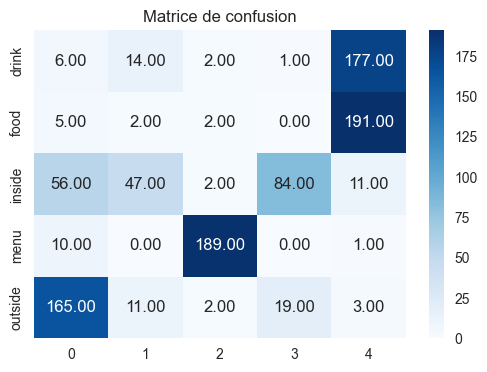

In [ ]:
conf_mat_vgg = confusion(labels_encoded, kmeans.labels_)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_vgg, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")

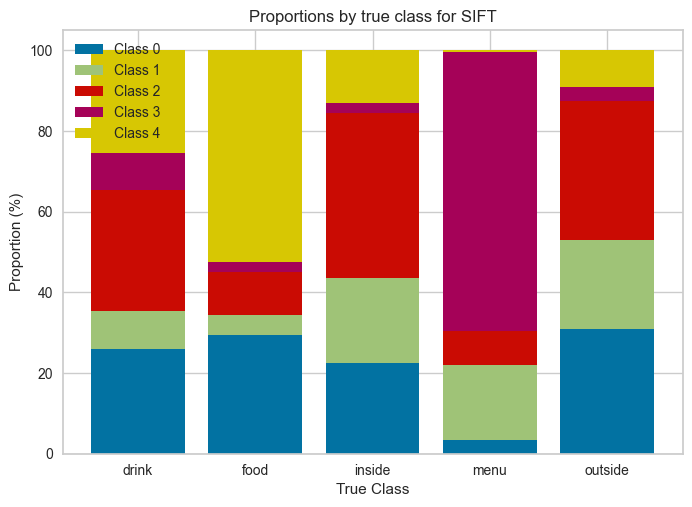

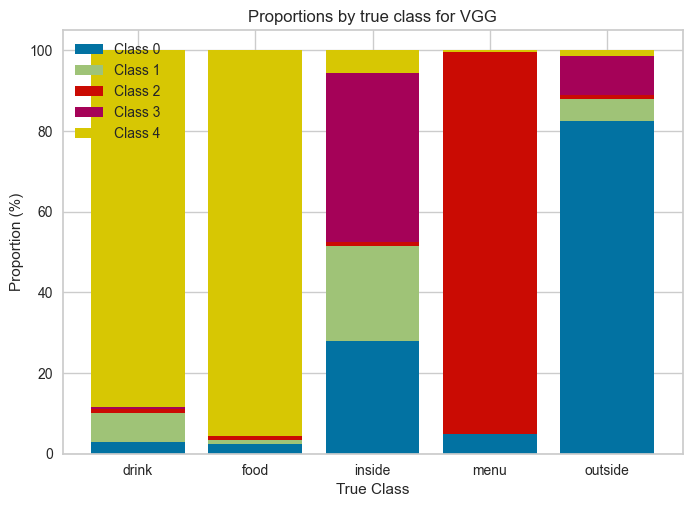

In [ ]:
def plot_stacked_bar(df, title):
    """
    Trace un diagramme à barres empilées à partir d'un DataFrame pour visualiser les proportions de classes prédites pour chaque
    classe réelle dans un problème de classification.

    Args:
        df (DataFrame): DataFrame à partir duquel le graphique est tracé.
                        Les lignes correspondent aux classes réelles et les colonnes aux classes prédites.
        title (str)   : Titre du graphique.
    """
    df = df.div(df.sum(axis=1), axis=0) * 100
    labels = df.index
    num_labels = len(labels)
    x = np.arange(num_labels)  

    fig, ax = plt.subplots()
    for i in range(df.shape[1]):
        if i == 0:
            ax.bar(x, df.iloc[:, i], label="Class " + str(i))
        else:
            ax.bar(
                x,
                df.iloc[:, i],
                bottom=df.iloc[:, :i].sum(axis=1),
                label="Class " + str(i),
            )

    ax.set_xlabel("True Class")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"Proportions by true class for {title}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


plot_stacked_bar(conf_mat_sift, "SIFT")
plot_stacked_bar(conf_mat_vgg, "VGG")

#### #### Enchaînement des étapes de nettoyage et de création de variables (VGG)


In [ ]:
class VGGFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Un transformateur personnalisé qui utilise le modèle VGG16 pour extraire les caractéristiques des images.
    """

    def __init__(self):
        self.model = VGG16(weights="imagenet", include_top=False)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features_vgg16 = []

        for img in X:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_size = (224, 224)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)

            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            features = self.model.predict(img_array)
            features_vgg16.append(features)

        return np.asarray(features_vgg16)


image_processing_pipeline = Pipeline(
    [
        ("sampler", Sampler(n_samples_per_label=10)),
        ("loader", ImageLoader(input_dir)),
        ("preprocessing", ImagePreprocessor()),
        ("feature_extraction", VGGFeatureExtractor()),
    ]
)

vgg_features = image_processing_pipeline.fit_transform(df_images)

1/1 [==============================] - 0s 79ms/step


In [ ]:
print(vgg_features.shape)

(50, 1, 7, 7, 512)


Nous avons bien récupéré nos 50 features extraites à partir de nos 10 images par label
